<a href="https://colab.research.google.com/github/Sara-DaCanal/Progetto-ML/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di Machine Learning

* Adrian Petru Baba
* Sara Da Canal

## Introduzione

Questo Notebook propone l'analisi di modelli di Machine Learning usati per eseguire una classificazione binaria su un dataset di funghi, per stabilire se sono commestibili o velenosi. Inizialmente abbiamo effettuato una fase di preprocessing dei dati, per andare ad ottenere un dataset di qualità, poi siamo andati a testare differenti modelli di machine learning effettuando tuning dei parametri per stabilire quale modello è il migliore per il task considerato.

In [161]:
import pandas as pd
from typing import Tuple
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KernelDensity, KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
path_to_dataset = '/content/drive/MyDrive/secondary_data_shuffled.csv'

In [5]:
df = pd.read_csv(path_to_dataset, sep=';')
print(df.columns)
print(df.shape)

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(61069, 21)


Abbiamo letto il dataset importandolo come un Dataframe pandas.
Come si può vedere qui sopra, il dataset comprende 21 colonne, di cui 20 sono feature e la prima è il valore target, e 61.069 righe. Di queste colonne, tre hanno valori numerici, mentre tutte le altre presentano valori categorici. Le colonne dei valori categorici sono indicate tramite singole lettere, il che rende il dataset di difficile lettura. In più, anche valori binari sono indicati con le lettere 't' ed 'f' invece che usare 0 e 1. Abbiamo quindi modificato il dataset per renderlo più leggibile. Dopo le modifiche è possibile vedere quante colonne sono categoriche, quante booleane e quante numeriche.

In [6]:
df['cap-shape'].replace(to_replace = 'b', value='bell', inplace=True)
df['cap-shape'].replace(to_replace = 'c', value='conical', inplace=True)
df['cap-shape'].replace(to_replace = 'x', value='convex', inplace=True)
df['cap-shape'].replace(to_replace = 'f', value='flat', inplace=True)
df['cap-shape'].replace(to_replace = 's', value='sunken', inplace=True)
df['cap-shape'].replace(to_replace = 'p', value='spherical', inplace=True)
df['cap-shape'].replace(to_replace = '0', value='other', inplace=True)

df['cap-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['cap-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['cap-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['cap-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['cap-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['cap-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['cap-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['cap-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['cap-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['cap-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['cap-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)

df['cap-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['cap-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['cap-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['cap-color'].replace(to_replace = 'r', value='green', inplace=True)
df['cap-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['cap-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['cap-color'].replace(to_replace = 'e', value='red', inplace=True)
df['cap-color'].replace(to_replace = 'w', value='white', inplace=True)
df['cap-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['cap-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['cap-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['cap-color'].replace(to_replace = 'k', value='black', inplace=True)

df['does-bruise-or-bleed'].replace(to_replace = 't', value=True, inplace=True)
df['does-bruise-or-bleed'].replace(to_replace = 'f', value=False, inplace=True)

df['gill-attachment'].replace(to_replace = 'a', value='adnate', inplace=True)
df['gill-attachment'].replace(to_replace = 'x', value='adnexed', inplace=True)
df['gill-attachment'].replace(to_replace = 'd', value='decurrent', inplace=True)
df['gill-attachment'].replace(to_replace = 'e', value='free', inplace=True)
df['gill-attachment'].replace(to_replace = 's', value='sinuate', inplace=True)
df['gill-attachment'].replace(to_replace = 'p', value='pores', inplace=True)
df['gill-attachment'].replace(to_replace = 'f', value='none', inplace=True)
df['gill-attachment'].replace(to_replace = '?', value='unknown', inplace=True)

df['gill-spacing'].replace(to_replace = 'c', value='close', inplace=True)
df['gill-spacing'].replace(to_replace = 'd', value='distant', inplace=True)
df['gill-spacing'].replace(to_replace = 'f', value='none', inplace=True)

df['gill-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['gill-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['gill-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['gill-color'].replace(to_replace = 'r', value='green', inplace=True)
df['gill-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['gill-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['gill-color'].replace(to_replace = 'e', value='red', inplace=True)
df['gill-color'].replace(to_replace = 'w', value='white', inplace=True)
df['gill-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['gill-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['gill-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['gill-color'].replace(to_replace = 'k', value='black', inplace=True)
df['gill-color'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-root'].replace(to_replace = 'b', value='bulbous', inplace=True)
df['stem-root'].replace(to_replace = 's', value='swollen', inplace=True)
df['stem-root'].replace(to_replace = 'c', value='club', inplace=True)
df['stem-root'].replace(to_replace = 'u', value='cup', inplace=True)
df['stem-root'].replace(to_replace = 'e', value='equal', inplace=True)
df['stem-root'].replace(to_replace = 'z', value='rhizomorphs', inplace=True)
df['stem-root'].replace(to_replace = 'r', value='rooted', inplace=True)

df['stem-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['stem-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['stem-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['stem-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['stem-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['stem-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['stem-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['stem-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['stem-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['stem-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['stem-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)
df['stem-surface'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['stem-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['stem-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['stem-color'].replace(to_replace = 'r', value='green', inplace=True)
df['stem-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['stem-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['stem-color'].replace(to_replace = 'e', value='red', inplace=True)
df['stem-color'].replace(to_replace = 'w', value='white', inplace=True)
df['stem-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['stem-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['stem-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['stem-color'].replace(to_replace = 'k', value='black', inplace=True)
df['stem-color'].replace(to_replace = 'f', value='none', inplace=True)

df['veil-type'].replace(to_replace = 'p', value=False, inplace=True)
df['veil-type'].replace(to_replace = 'u', value=True, inplace=True)
df['veil-type'].rename("universal-veil")

df['veil-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['veil-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['veil-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['veil-color'].replace(to_replace = 'r', value='green', inplace=True)
df['veil-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['veil-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['veil-color'].replace(to_replace = 'e', value='red', inplace=True)
df['veil-color'].replace(to_replace = 'w', value='white', inplace=True)
df['veil-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['veil-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['veil-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['veil-color'].replace(to_replace = 'k', value='black', inplace=True)
df['veil-color'].replace(to_replace = 'f', value='none', inplace=True)

df['has-ring'].replace(to_replace = 't', value=True, inplace=True)
df['has-ring'].replace(to_replace = 'f', value=False, inplace=True)

df['ring-type'].replace(to_replace = 'c', value='cobwebby', inplace=True)
df['ring-type'].replace(to_replace = 'e', value='evanescent', inplace=True)
df['ring-type'].replace(to_replace = 'r', value='flaring', inplace=True)
df['ring-type'].replace(to_replace = 'g', value='grooved', inplace=True)
df['ring-type'].replace(to_replace = 'l', value='large', inplace=True)
df['ring-type'].replace(to_replace = 'p', value='pendant', inplace=True)
df['ring-type'].replace(to_replace = 's', value='sheathing', inplace=True)
df['ring-type'].replace(to_replace = 'z', value='zone', inplace=True)
df['ring-type'].replace(to_replace = 'y', value='scaly', inplace=True)
df['ring-type'].replace(to_replace = 'm', value='movable', inplace=True)
df['ring-type'].replace(to_replace = 'f', value='none', inplace=True)

df['spore-print-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['spore-print-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['spore-print-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['spore-print-color'].replace(to_replace = 'r', value='green', inplace=True)
df['spore-print-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['spore-print-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['spore-print-color'].replace(to_replace = 'e', value='red', inplace=True)
df['spore-print-color'].replace(to_replace = 'w', value='white', inplace=True)
df['spore-print-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['spore-print-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['spore-print-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['spore-print-color'].replace(to_replace = 'k', value='black', inplace=True)

df['habitat'].replace(to_replace = 'g', value='grasses', inplace=True)
df['habitat'].replace(to_replace = 'l', value='leaves', inplace=True)
df['habitat'].replace(to_replace = 'm', value='meadows', inplace=True)
df['habitat'].replace(to_replace = 'p', value='paths', inplace=True)
df['habitat'].replace(to_replace = 'h', value='heaths', inplace=True)
df['habitat'].replace(to_replace = 'u', value='urban', inplace=True)
df['habitat'].replace(to_replace = 'w', value='waste', inplace=True)
df['habitat'].replace(to_replace = 'd', value='woods', inplace=True)

df['season'].replace(to_replace = 's', value='spring', inplace=True)
df['season'].replace(to_replace = 'u', value='summer', inplace=True)
df['season'].replace(to_replace = 'w', value='winter', inplace=True)
df['season'].replace(to_replace = 'a', value='autumn', inplace=True)

df['class'].replace(to_replace = 'e', value=True, inplace=True)
df['class'].replace(to_replace = 'p', value=False, inplace=True)

In [7]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print("Le feature numeriche sono:" ,numerical_cols)
print("Il numero di feature numeriche è:", len(numerical_cols))
categorical_cols = df.select_dtypes(include='object').columns.to_list()
print("Le feature categoriche sono:" ,categorical_cols)
print("Il numero di feature categoriche è:", len(categorical_cols))
boolean_cols = df.select_dtypes(include='bool').columns.to_list()
print("Le feature booleane sono:" ,boolean_cols)
print("Il numero di feature boolean è:", len(boolean_cols))

Le feature numeriche sono: ['cap-diameter', 'stem-height', 'stem-width']
Il numero di feature numeriche è: 3
Le feature categoriche sono: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
Il numero di feature categoriche è: 15
Le feature booleane sono: ['class', 'does-bruise-or-bleed', 'has-ring']
Il numero di feature boolean è: 3


## Preprocessing del dataset
Per andare ad ottenere un dataset coerente siamo andati a verificare la presenza di valori nulli nelle colonne, usando la seguente funzione:

In [8]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface          14120
gill-attachment       9884
gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
ring-type             2471
spore-print-color    54715
dtype: int64


Come si può vedere dall'output, abbiamo valori nulli in 9 colonne su 20.

In questa fase abbiamo eliminato dal dataset le colonne relative a feature in cui c'è una percentuale di valori nulli maggiore rispetto a una specifica soglia (nello specifico **75%**).
Possiamo vedere il numero minimo di valori non nulli richiesto per non cancellare la colonna.
Dal numero iniziale, con questa pulizia rimangono solo **14** feature.

In [9]:
righe = df.shape[0]
p = 0.75
def remove_nan_columns(dataset: pd.DataFrame, threshold) -> pd.DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold)) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset

new_data = remove_nan_columns(df, p)
print("Il numero di feature ora è:" ,new_data.shape[1])



Numero di valori non nulli minimo:  45802
Il numero di feature ora è: 15


In [10]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()

categorical_cols = df.select_dtypes(include='object').columns.to_list()

boolean_cols = df.select_dtypes(include='bool').columns.to_list()
print('Abbiamo', len(numerical_cols), 'colonne numeriche,', len(categorical_cols), 'colonne categoriche e', len(boolean_cols), 'colonne booleane.')

Abbiamo 3 colonne numeriche, 9 colonne categoriche e 3 colonne booleane.


Di seguito possiamo vedere quali, fra le rimanenti feature, hanno qualche valore nullo (ma non a sufficienza per essere cancellate in base al threshold scelto).
Di fatto, tra le colonne riguardanti feature con valori numerici o booleani, non abbiamo alcun valore null; al contrario, per le feature con valori categorici, abbiamo diversi null.
Nel caso categorico, abbiamo scelto di riempire gli spazi vuoti con la moda del valore della feature corrispondente.

In [11]:
nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface        14120
gill-attachment     9884
ring-type           2471
dtype: int64


Qui di seguito andiamo a calcolare la moda per le colonne considerate, andando anche a mostrare, nei grafici a torta, le distribuzioni percentuali dei diversi valori, in modo da poter visualizzare se la moda copre effettivamente una parte significativa dei valori oppure se ci sono valori che hanno tutti percentuali molto simili tra loro. Come si può vedere, in tutti e tre i casi la moda è molto significativa, quindi la nostra scelta sembra corretta.

La moda per la colonna cap-surface è: sticky
La moda per la colonna gill-attachment è: adnate
La moda per la colonna ring-type è: none


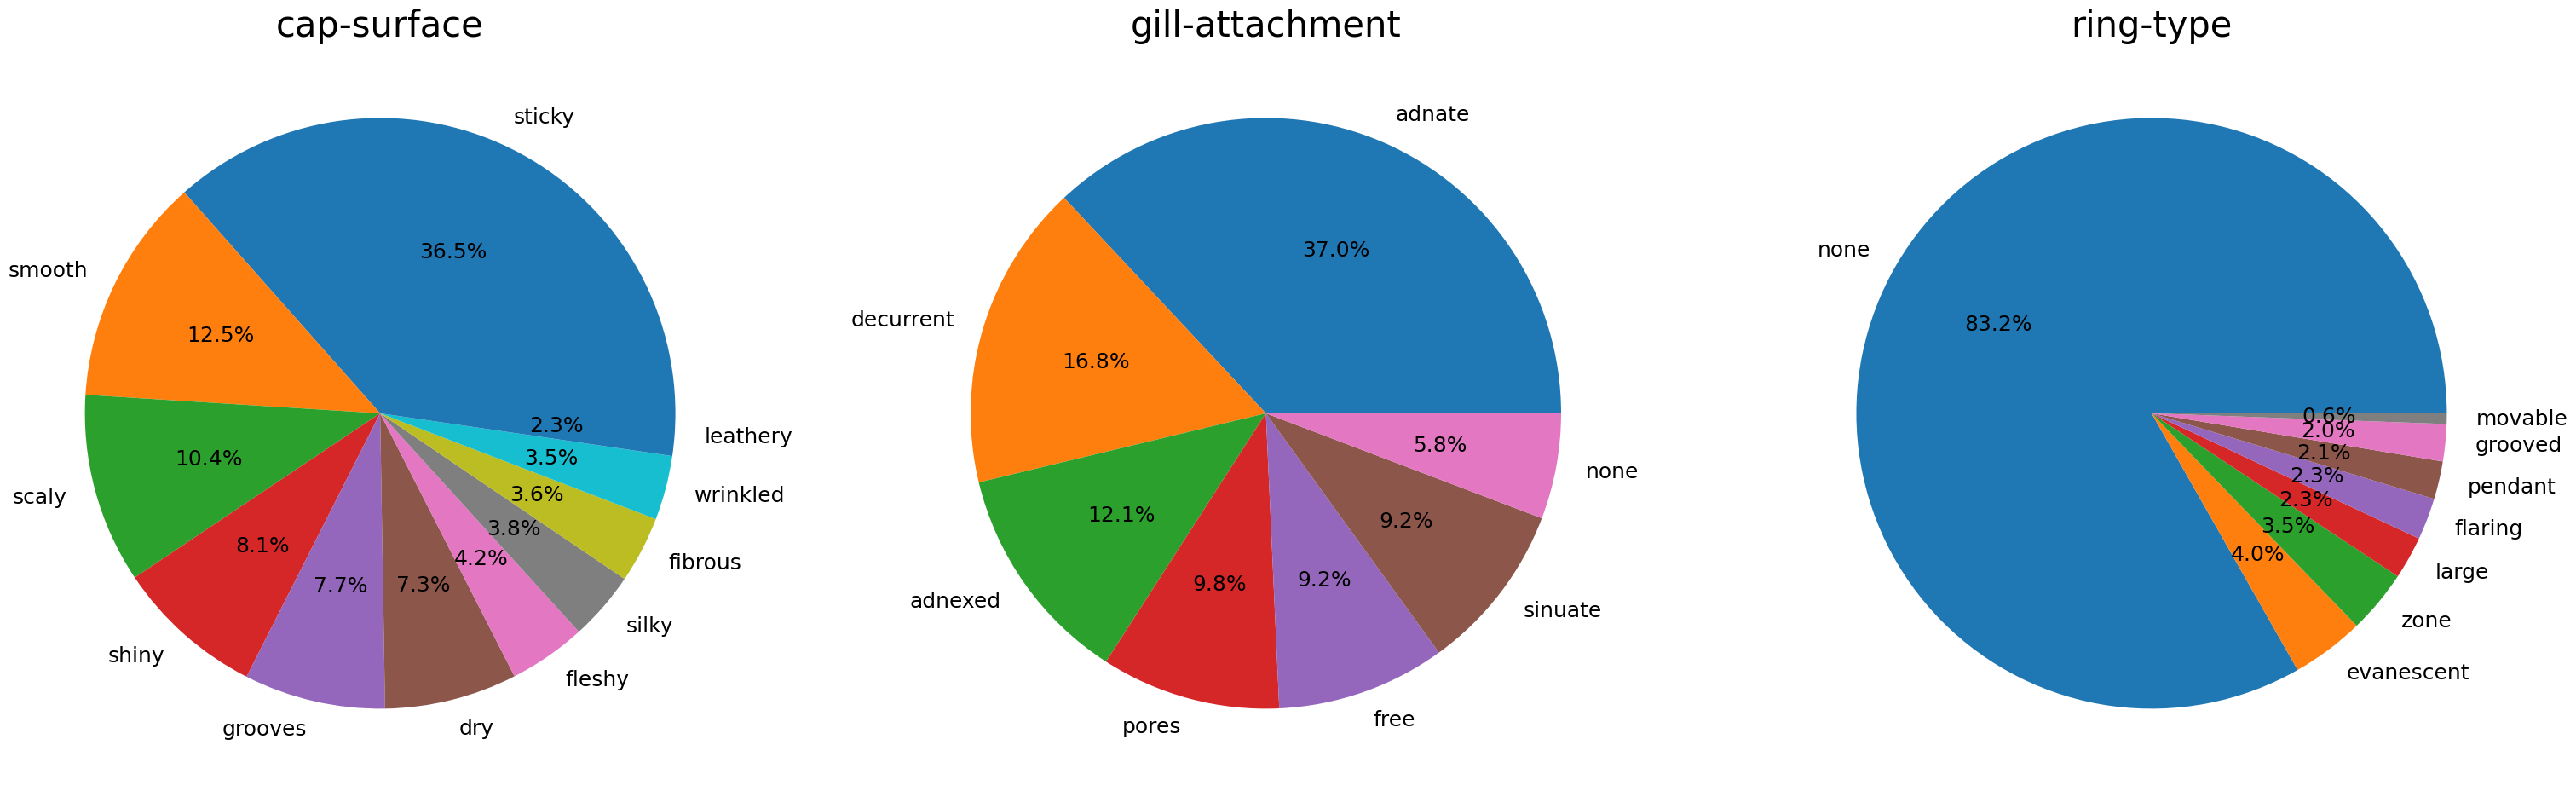

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(38, 15))
y=0
for elem in categorical_cols:
  if elem in nan_list:
    col = df[elem]
    mode = col.mode()
    print('La moda per la colonna', col.name, 'è:', mode.iloc[0])
    df1 = col.fillna(mode.iloc[0], inplace=True)
    percentages = col.value_counts(normalize=True) * 100
    ax = percentages.plot.pie(ax=axes[y], autopct='%1.1f%%', fontsize=18)
    ax.set_title(col.name, fontsize=30)

    ax.set_ylabel('')
    y+=1
plt.show()


Il grafico seguente mostra le correlazioni tra le tre colonne con valori NaN e il target. Come possiamo vedere, alcune categorie hanno una correlazione con il target abbastanza alta, ovvero hanno una media dei risultati molto spostata verso i positivi o i negativi. Le tre categorie prese come moda però hanno una correlazione abbastanza bassa, con valori di 0.43, 0.37 e 0.45 rispettivamente, quindi sostituire i NaN con la moda non rende il dataset inconsistente.

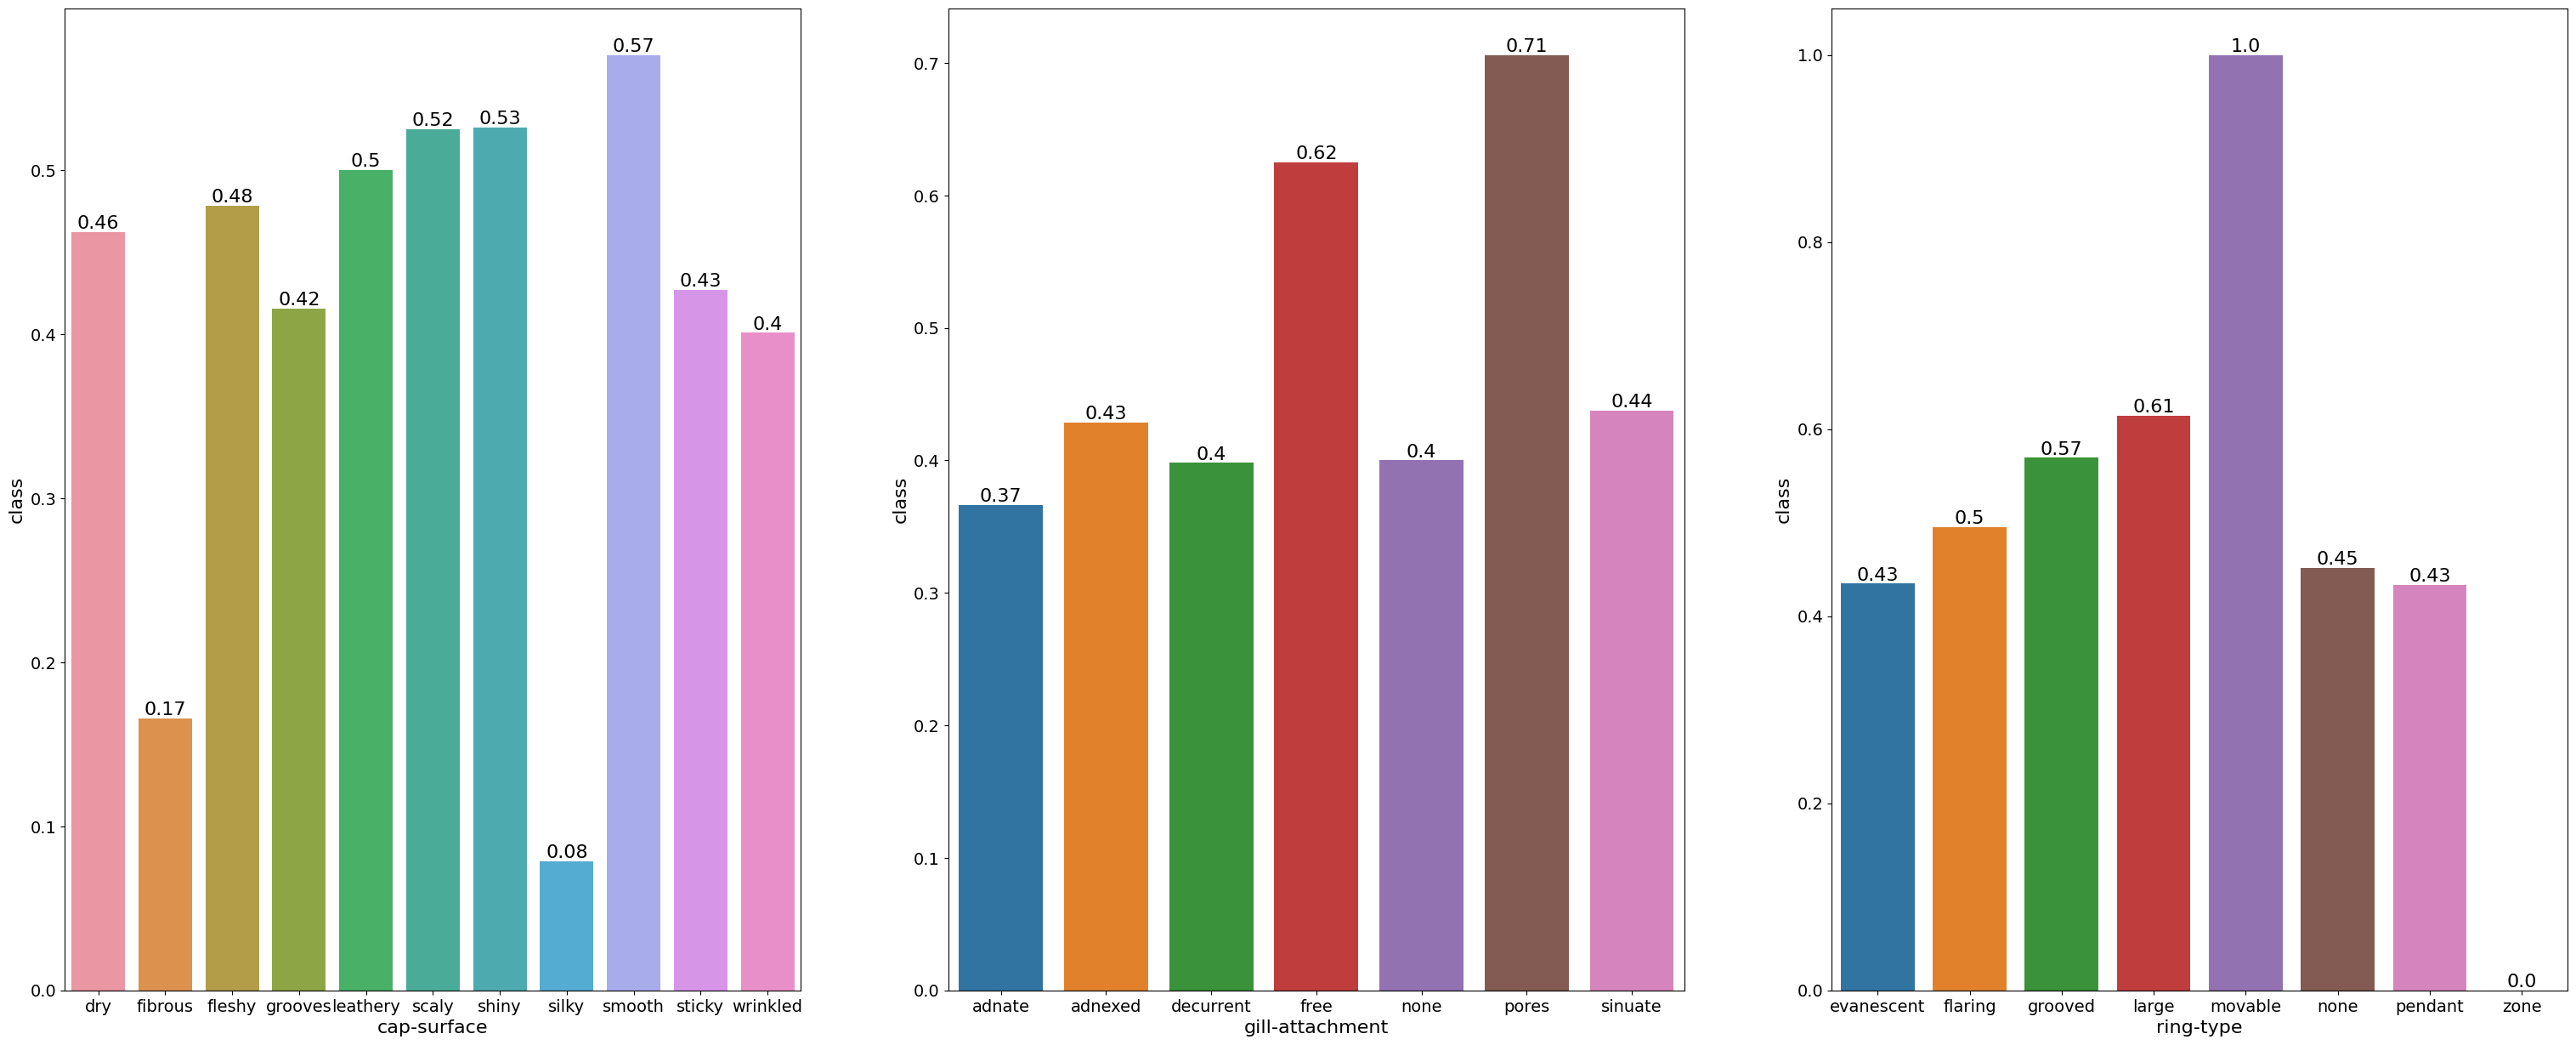

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(38, 15))
y = 0
target = df['class']
for elem in nan_list:
  col = df[elem]
  correlation = df.groupby(col.name)[target.name].mean().reset_index()


  ax = sns.barplot(x=col.name, y=target.name, data=correlation, ax=axes[y])

  for i, val in enumerate(correlation[target.name]):
    axes[y].text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontsize=16)
  axes[y].set_xlabel(col.name, fontsize=16)
  axes[y].set_ylabel(target.name, fontsize=16)

  ax.tick_params(axis='x', labelsize=14)
  ax.tick_params(axis='y', labelsize=14)
  y+=1


# Mostra il grafico
plt.show()


L'ultimo controllo da fare è vedere se le classi target sono bilanciate. Come si può vedere sotto abbiamo il 45% delle righe che contengono funghi commestibili e il 55% delle righe con funghi velenosi. Abbiamo un leggero sbilanciamento verso i funghi velenosi ma può essere considerato accettabile

In [14]:
target = df['class']
print('Number of edible items: {0:d}'.format(df[target==1].shape[0]))
print('Number of poisonous items: {0:d}'.format(df[target==0].shape[0]))
print('Fraction of edible items: {0:3.2f}'.format(df[target==1].shape[0]/df.shape[0]))

Number of edible items: 27181
Number of poisonous items: 33888
Fraction of edible items: 0.45


### One Hot Encoding
L'ultimo passo nel preprocessamento del nostro dataset è andare a convertire le variabili categoriche che abbiamo in variabili numeriche, per poterle usare in modelli di machine learning. L'encoding one-hot è una tecnica di trasformazione che crea variabili dummy per ogni categoria presente nella variabile categorica. Queste variabili assumeranno il valore 1 se l'osservazione corrisponde alla categoria corrispondente e 0 altrimenti. Questo tipo di encoding viene utilizzato quando non esiste un'ordine intrinseco tra le categorie, come succede in tutte le categorie che dobbiamo convertire. Come si può vedere, dopo aver applicato il one hot encoding, abbiamo 88 colonne nel nostro dataset. Nel dataset con one hot encoding convertiamo anche i booleani in interi, per avere un dataset totalmente numerico.

In [15]:
df_encoded = pd.get_dummies(df, columns=categorical_cols)
for elem in boolean_cols:
  df_encoded[elem] = df_encoded[elem].astype(int)
print("Il nuovo numero di colonne è:",df_encoded.shape[1])

Il nuovo numero di colonne è: 88


## Selezione dei modelli
Andiamo a considerare diversi modelli, per andare a stabilire quale è il migliore per la nostra classificazione. Per ogni modello calcoliamo l'accuracy e l'f2-score. L'accuracy è uno score che rappresenta le predizioni corrette rispetto al totale delle predizioni, mentre l'f2-score calcola una metrica combinando precision e recall e dando un maggior peso alla recall dei risultati positivi, quindi nel nostro caso dà un peso più alto a funghi velenosi erroaneamente classificati come commestibili, motivo per cui ci è sembrata la scelta migliore.
Per separare il nostro dataset in training set e testing set abbiamo usato la k-fold-cross-validation, che consiste nel dividere il dataset in k fold e usare ad ogni iterazione uno dei fold come testing set e i restanti k-1 come training set. Viste le dimensioni del dataset, abbiamo deciso di usare 10 fold.

In [175]:
c=10
def ConfusionMatrixDisplay(cm, y, ax, s):
  ax[y].imshow(cm, cmap=plt.cm.Blues)
  title = 'Matrice di Confusione per '+s
  ax[y].set_title(title)
  ax[y].set_xticks([0, 1], ['Velenoso', 'Commestibile'])
  ax[y].set_yticks([0, 1], ['Velenoso', 'Commestibile'])
  ax[y].set_xlabel('Previsto')
  ax[y].set_ylabel('Reale')

  # Aggiunta dei valori all'interno delle celle
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[y].text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
def ConfusionMatrixDisplaySingle(cm, s):
  plt.imshow(cm, cmap=plt.cm.Blues)
  title = 'Matrice di Confusione per '+s
  plt.title(title)
  plt.xticks([0, 1], ['Velenoso', 'Commestibile'])
  plt.yticks([0, 1], ['Velenoso', 'Commestibile'])
  plt.xlabel('Previsto')
  plt.ylabel('Reale')

  # Aggiunta dei valori all'interno delle celle
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


### Linear Discriminant Analysis
Questo metodo di classificazione si basa su un decision bound, in questo caso in cui le feature sono multi-dimensionali un iperpiano. Quando usiamo la classificazione LDA per fare classificazione binaria, il decision bound ha la forma:
$$ y(x)= w^T x+w_0 $$
e lo spazio viene separato in due regioni. Si decide a quale regione appartiene $x$ in base al segno del risultato della funzione nel punto da classificare.
Normalmente la classificazione LDA si basa sulla massimizzazione della distanza tra i punti medi delle due classi, cercando il parametro $w$ migliore come
$$ max_w \ w^T(m_2 - m_1) $$.
Questo può portare risultati non ottimali nel momento in cui le classi hanno una varianza molto elevata, in quel caso si usa il criterio di Fischer per cui il valore da massimizzare è:
$$ max_w\ J(w)=\frac{(m_2-m_1)^2}{s_1^2+s_2^2} $$

LDA senza considerare la varianza dà accuracy: 0.7739769768622378 ,f2-score: 0.7933120096488686 e f3 score: 0.7926067476128171
LDA senza considerando la varianza dà accuracy: 0.7739769768622378 ,f2-score: 0.7933120096488686 e f3-score: 0.7926067476128171


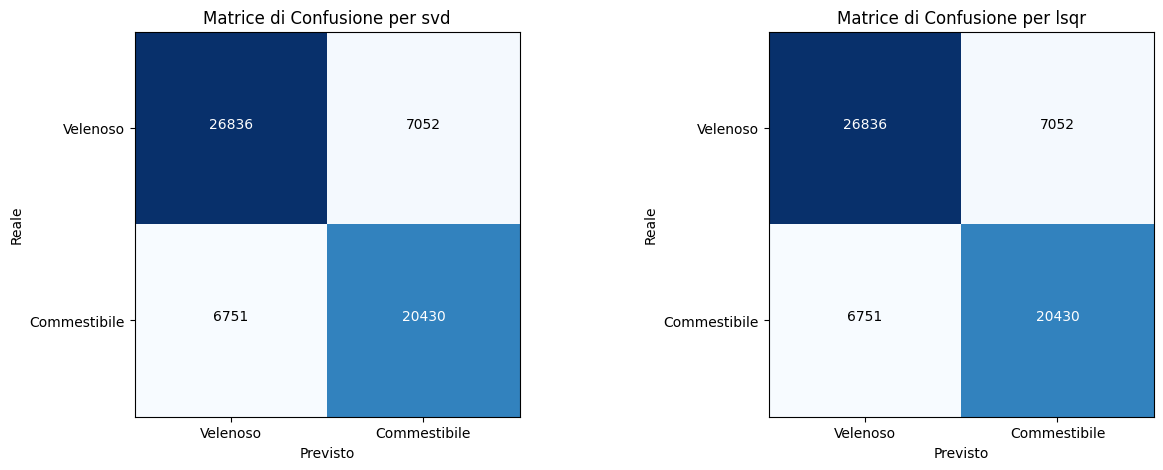

In [102]:
x_train = df_encoded[df_encoded.columns.to_list()[1:]]
y_train = df_encoded['class']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = cross_val_predict(lda, x_train, y_train, cv=c)
# Calcola e salva la metrica di valutazione (ad es. accuratezza)
accuracy1 = accuracy_score(y_train, y_pred)
f2_score1 = fbeta_score(y_train, y_pred, beta=2, pos_label = 0)
f3_score1 = fbeta_score(y_train, y_pred, beta=3, pos_label = 0)
print("LDA senza considerare la varianza dà accuracy:", accuracy1, ",f2-score:", f2_score1, "e f3 score:", f3_score1)
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred), 0, axes, 'svd')

lda2 = LinearDiscriminantAnalysis(solver='lsqr')
y_pred = cross_val_predict(lda2, x_train, y_train, cv=c)
accuracy2 = accuracy_score(y_train, y_pred)
f2_score2 = fbeta_score(y_train, y_pred, beta=2, pos_label = 0)
f3_score2 = fbeta_score(y_train, y_pred, beta=3, pos_label = 0)
print("LDA senza considerando la varianza dà accuracy:", accuracy2, ",f2-score:", f2_score2, "e f3-score:", f3_score2)
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred), 1, axes, 'lsqr')
plt.show()
f2_score_LDA = f2_score1



Sopra sono mostrate le matrici di confusione per LDA in entrambi i modi di esecuzione. Come si può vedere, usare un metodo o l'altro non cambia i risultati, che in ogni caso non sono ottimali, mostrando come il dataset non sia linearmente separabile.

### Naive Bayes
Naive Bayes è un classificatore generativo che calcola la probabilità che un elemento appartenga a una classe come:
$$ p(C_k|x)=\frac{p(x|C_k)P(C_k)}{p(x)} $$
Dove $ P(C_k) $ viene detta distribuzione a priori e assunta Gaussiana.

Naive Bayes da accuracy: 0.7196286168104931 , f2-score: 0.7700396131888617 e f3-score: 0.7750513046027557


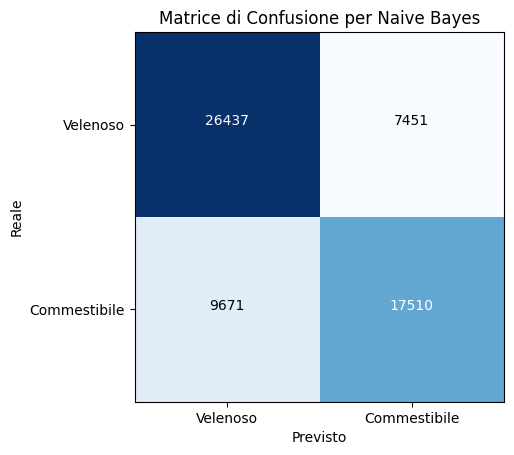

In [103]:
nb = GaussianNB()

x_train = df_encoded[df_encoded.columns.to_list()[1:]]
y_train = df_encoded['class']
y_pred = cross_val_predict(nb, x_train, y_train, cv=c)
accuracy = accuracy_score(y_train, y_pred)

f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label = 0)
f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label = 0)
ConfusionMatrixDisplaySingle(confusion_matrix(y_train, y_pred), 'Naive Bayes')

print("Naive Bayes da accuracy:", accuracy, ", f2-score:", f2_score, "e f3-score:", f3_score)
plt.show()
f2_score_NB = f2_score

Come si può vedere dai risultati, Naive Bayes da risultati non ottimi come classificatore sul nostro dataset, ha un accuratezza minore rispetto a LDA, che già non aveva buone performance. Questo è dato probabilmente dal fatto che questo classificatore assume una distribuzione normale, che potrebbe essere sbagliata per il dataset considerato.

### Logistic Regression
La regressione logistica è un modello discriminativo per la classificazione, in cui si assume che i target abbiano una distribuzione bernoulliana. Da qui deriva la funzione predittiva
$$ p(C|x)=\frac{1}{1+e^{-\theta (x)}} $$
dove $ \theta (x) = w^T\bar x $.
Questo modello può essere migliorato con una funzione di penalità per andare a limitare l'overfittig. Possiamo usare valori diversi per il parametro di regolarizzazione della penalità

In [22]:
max_log = [[0,0,0], [0,0,0], [0,0,0]]
def update(target, C, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>max_log[i][0]:
      max_log[i][0] = target[i]
      max_log[i][1] = C
      max_log[i][2] = conf_matrix


In [23]:
C=[0.01, 0.05, 0.1, 0.25, 0.4, 0.5, 0.75, 1.0, 1.5]
accuracy_scores=[]
f2_scores=[]
f3_scores = []
cms = []
max_log = [[0,0,0], [0,0,0], [0,0,0]]
for x in C:
  logreg = LogisticRegression(penalty='l2', C=x, solver='newton-cholesky', max_iter=1000)

  # Effettuare previsioni con la validazione incrociata
  y_pred = cross_val_predict(logreg, x_train, y_train, cv=c)

  # Calcolare l'accuratezza delle previsioni
  accuracy = accuracy_score(y_train, y_pred)
  accuracy_scores.append(accuracy)
  f2_score=fbeta_score(y_train, y_pred, beta=2, pos_label=0)
  f2_scores.append(f2_score)
  f3_score=fbeta_score(y_train, y_pred, beta=3, pos_label=0)
  f3_scores.append(f2_score)
  cm = confusion_matrix(y_train, y_pred)
  cms.append(cm)
  update([f2_score, f3_score, accuracy], x, cm)

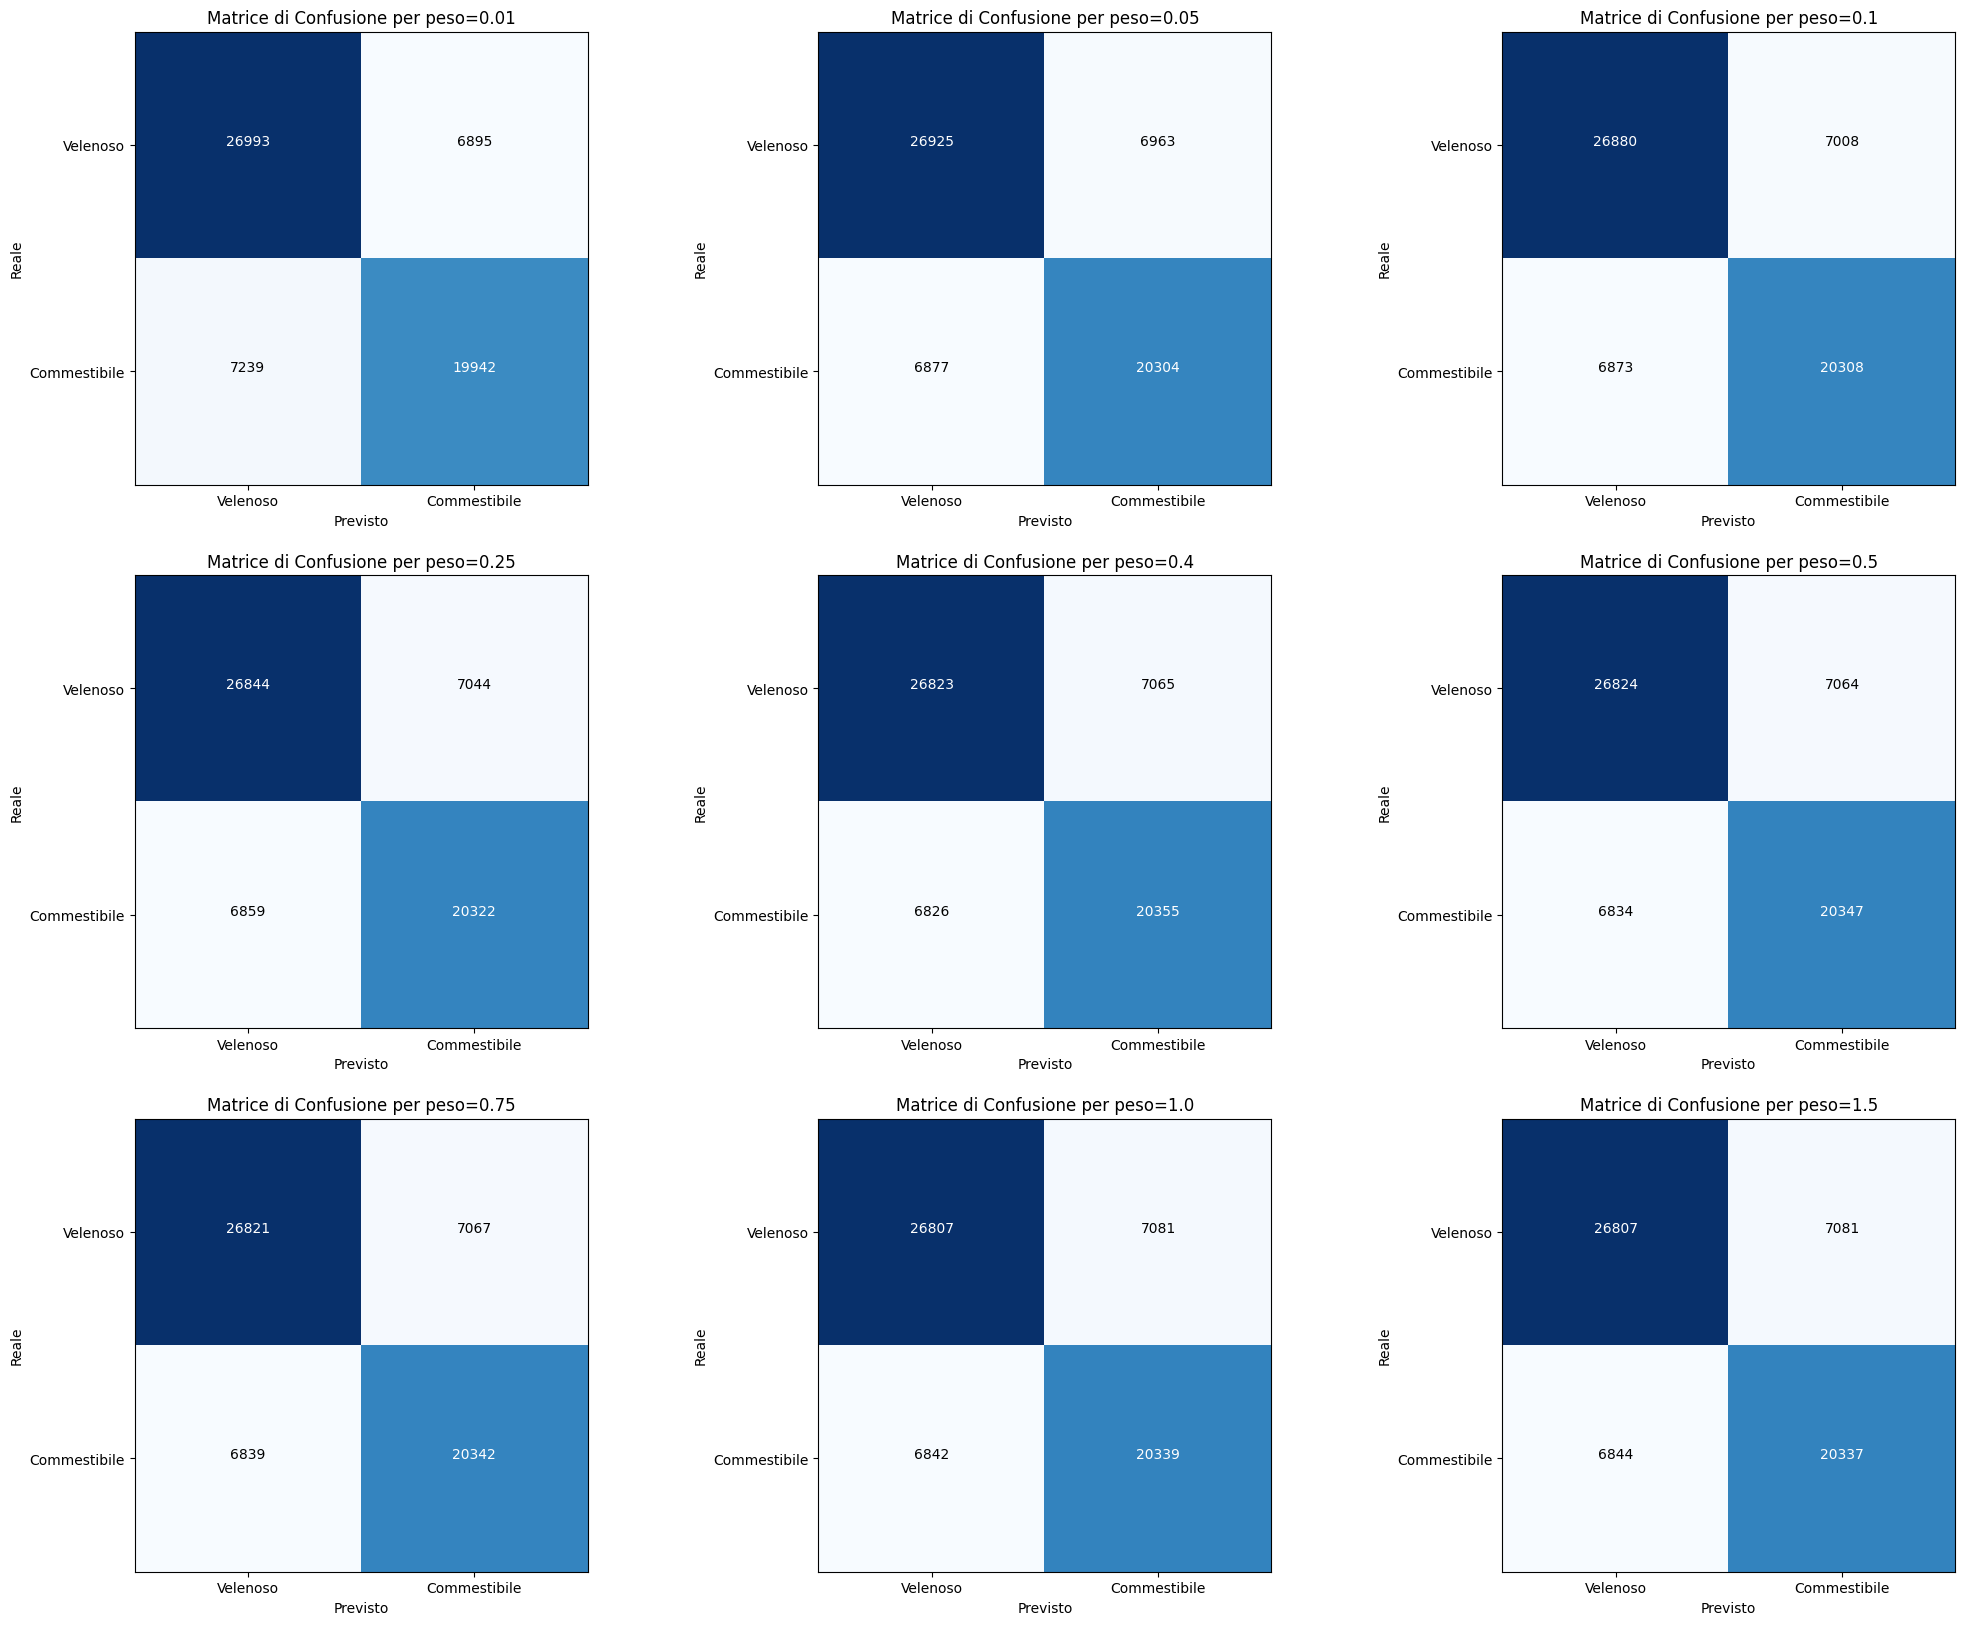

In [109]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))
x=0
y=0
i=0
for cm in cms:
  ConfusionMatrixDisplay(cm, y, axes[x], 'peso='+str(C[i]))
  i+=1
  if y==2:
    y=0
    x+=1
  else:
    y+=1
plt.show()

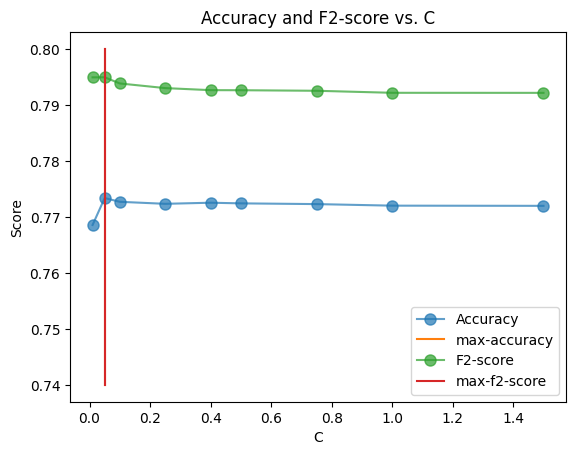

MAX f2_score:  0.7949325082371836
for C:  0.05
MAX f3_score:  0.7957278966110889
for C:  0.01
MAX accuracy:  0.773371104815864
for C:  0.05


In [26]:
max_C_acc = max_log[2][1]
max_C_f2 = max_log[0][1]
    # Tracciamento del grafico

plt.plot(C, accuracy_scores, 'o-', markersize=8, alpha=0.7, label='Accuracy')
plt.plot([max_C_acc, max_C_acc], [0.74, 0.80], label='max-accuracy')
plt.plot(C, f2_scores, 'o-', markersize=8, alpha=0.7, label='F2-score')
plt.plot([max_C_f2, max_C_f2], [0.74, 0.80], label='max-f2-score')
plt.legend()
plt.xlabel('C')
plt.ylabel('Score')

plt.title('Accuracy and F2-score vs. C')
plt.show()
print("MAX f2_score: ",max_log[0][0])
print("for C: ",max_log[0][1])

print("MAX f3_score: ",max_log[1][0])
print("for C: ",max_log[1][1])

print("MAX accuracy: ",max_log[2][0])
print("for C: ",max_log[2][1])

Come si può vedere dai grafici, una penalità troppo alta, quindi un parametro C piccolo, porta ad un modello molto inaccurato, mentre una penalità piccola porta ad un modello probabilmente overfitting. L'accuracy e l'f2 score migliori si ottengono per C = 0.05. Anche qui le performance, per quanto migliorate, ancora non sono particolarmente buone.

### Perceptron
Il percettrone è un altro modello lineare che generalizza rispetto al modello LDA, infatti si introduce una funzione per cui il modello diventa:
$$ y(x)=f(w^T \bar x) $$
$f(x)$ solitamente è la funzione segno.

for  l1  we have acc = 0.7013542058982463 , f2:  0.7360089448596481 , f3:  0.7370716327312372
for  l2  we have acc = 0.6151238762711032 , f2:  0.5851558579838206 , f3:  0.5745693358729549


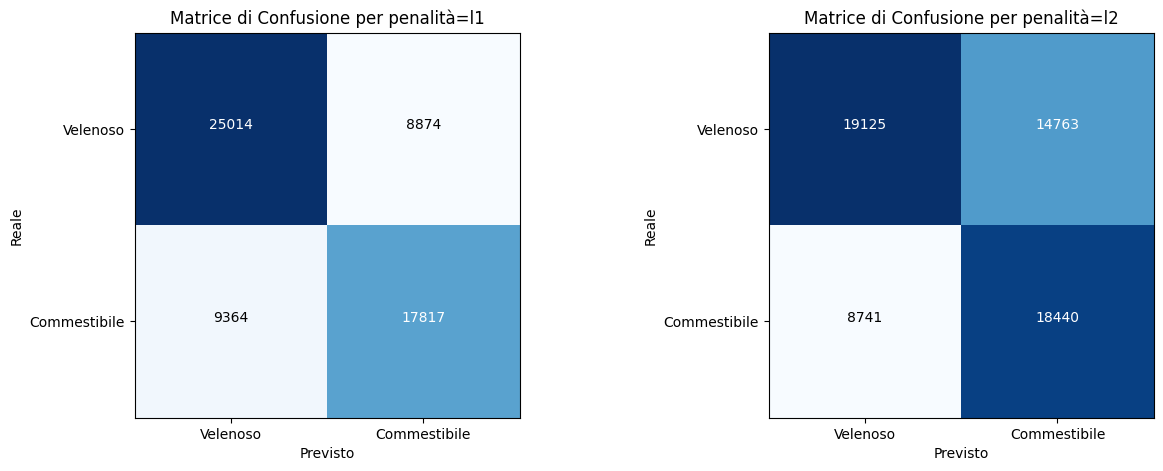

In [104]:
penalties = ['l1', 'l2']
random_state = 37

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
y = 0
max_perc = 0
for pen in penalties:

    x_train = df_encoded[df_encoded.columns.to_list()[1:]]
    y_train = df_encoded['class']

    #degree ignored for kernel != poly
    perc = Perceptron(penalty = pen, random_state = random_state )
    y_pred = cross_val_predict(estimator = perc, X=x_train, y=y_train, cv=10)
    cm = confusion_matrix(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
    f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)
    if f2_score >= max_perc:
      max_perc = f2_score
    print("for ",pen," we have acc =",accuracy,", f2: ",f2_score,", f3: ",f3_score)
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred), y, axes, 'penalità='+pen)
    y+=1

Come si può osservare, le metriche di accuratezza e f2 sono migliori per un percettrone basilare con penalità l1, ma comunque i valori sono abbastanza bassi.

### K-Nearest Neighbour
Questo metodo di classificazione è un metodo non parametrico, questo significa che la predizione viene ricavata direttamente dai dati senza assumere una distribuzione di probabilità. Si fissa un parametro K che corrisponde al numero di item più vicini da considerare, e si assegna al target la classe maggioritaria tra le classi dei vicini. Andiamo a misurare le performance con diversi valori di k per trovare i parametri migliori per il modello. Un altro parametro da far variare è la metrica con cui viene calcolata la distanza, per stabilire quali punti sono vicini. In particolare, andiamo a testare i diversi valori di K per ogni metrica.

In [105]:
knn_maxs = [[0,0,0,0],[0,0,0,0], [0,0,0,0]]
class KInfo:
    def __init__(self, k=0, metrics='', accuracy=0, f2=0, conf_matrix=0):
        self.k = k
        self.metrics = metrics
        self.accuracy = accuracy
        self.f2 = f2
        self.conf_matrix = conf_matrix

    def get_metrics(self):
        return self.metrics
    def get_k(self):
        return self.k
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_conf(self):
        return self.conf_matrix

def update(target, k, metrics, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>knn_maxs[i][0]:
      knn_maxs[i][0] = target[i]
      knn_maxs[i][1] = k
      knn_maxs[i][2] = metrics
      knn_maxs[i][3] = conf_matrix

In [106]:
x_train = df_encoded[df_encoded.columns.to_list()[1:]]
y_train = df_encoded['class']
ks = [1, 21, 31, 51, 101, 501]
metrics = ['euclidean', 'chebyshev', 'manhattan']
info = []
for m in metrics:
  for k in ks:
        knn = KNN(n_neighbors=k, metric='euclidean')
        y_pred = cross_val_predict(knn, x_train, y_train, cv=c)
        accuracy = accuracy_score(y_train, y_pred)
        f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
        f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)
        update([f2_score, f3_score, accuracy], k, m, cm)
        info.append(KInfo(k, m, accuracy, f2_score, confusion_matrix(y_train,y_pred)))

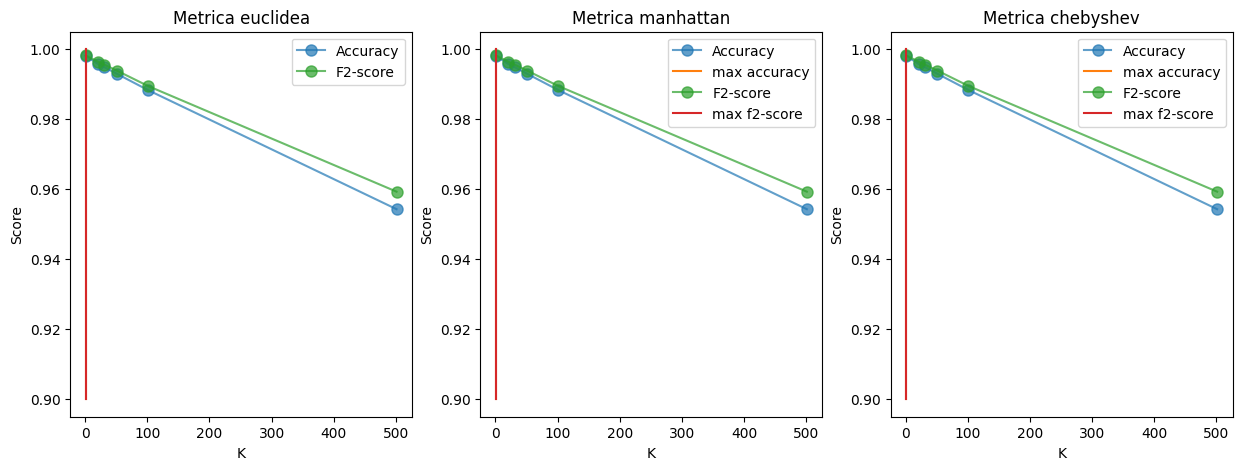

In [110]:
e_acc = []
m_acc = []
c_acc = []
e_f2 = []
m_f2 = []
c_f2 = []
    # Tracciamento del grafico
for elem in info:
  if elem.get_metrics() == 'euclidean':
    e_acc.append(elem.get_acc())
    e_f2.append(elem.get_f2())
  elif elem.get_metrics() == 'manhattan':
    m_acc.append(elem.get_acc())
    m_f2.append(elem.get_f2())
  else:
    c_acc.append(elem.get_acc())
    c_f2.append(elem.get_f2())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(ks, e_acc, 'o-', markersize=8, alpha=0.7, label='Accuracy')
axes[0].plot([knn_maxs[2][0], knn_maxs[2][0]], [0.90, 1.0])
axes[0].plot(ks, e_f2, 'o-', markersize=8, alpha=0.7, label='F2-score')
axes[0].plot([knn_maxs[0][0], knn_maxs[0][0]], [0.90, 1.0])
axes[0].legend()
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')

axes[0].set_title('Metrica euclidea')

axes[1].plot(ks, m_acc, 'o-', markersize=8, alpha=0.7, label='Accuracy')
axes[1].plot([knn_maxs[1][0], knn_maxs[1][0]], [0.90, 1.0], label='max accuracy')
axes[1].plot(ks, m_f2, 'o-', markersize=8, alpha=0.7, label='F2-score')
axes[1].plot([knn_maxs[0][0], knn_maxs[0][0]], [0.90, 1.0], label='max f2-score')
axes[1].legend()
axes[1].set_xlabel('K')
axes[1].set_ylabel('Score')

axes[1].set_title('Metrica manhattan')

axes[2].plot(ks, c_acc, 'o-', markersize=8, alpha=0.7, label='Accuracy')
axes[2].plot([knn_maxs[1][0], knn_maxs[1][0]], [0.90, 1.0], label='max accuracy')
axes[2].plot(ks, c_f2, 'o-', markersize=8, alpha=0.7, label='F2-score')
axes[2].plot([knn_maxs[0][0], knn_maxs[0][0]], [0.90, 1.0], label='max f2-score')
axes[2].legend()
axes[2].set_xlabel('K')
axes[2].set_ylabel('Score')

axes[2].set_title('Metrica chebyshev')


  # Mostra il grafico
plt.show()

Come si può vedere dai dati visualizzati qui sopra, variare la metrica di distanza non provoca cambiamenti nelle predizioni. Variare il parametro K invece influisce, si vede in particolare che al crescere del K le predizioni peggiorano. Con un parametro K=1 sia l'accuratezza che l'f2-score hanno valori molto buoni, i migliori ottenuti per ora. Qui sotto mostriamo la matrice di confusione con k = 1 per la metrica euclidea, anche se come si vede dal grafico sarebbe uguale per tutte le metriche.

MAX f2_score:  0.99824124458504
for K:  1
MAX f3_score:  0.9982353531359369
for K:  1
MAX accuracy:  0.9980677594196729
for K:  1


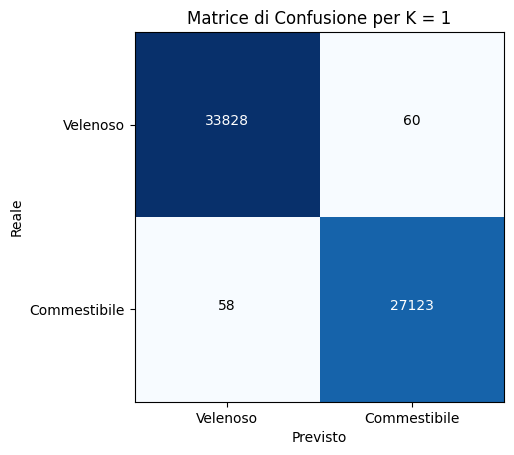

In questa configurazione abbiamo accuracy: 0.9980677594196729 e f2-score: 0.99824124458504


In [111]:
print("MAX f2_score: ",knn_maxs[0][0])
print("for K: ",knn_maxs[0][1])

print("MAX f3_score: ",knn_maxs[1][0])
print("for K: ",knn_maxs[1][1])

print("MAX accuracy: ",knn_maxs[2][0])
print("for K: ",knn_maxs[2][1])

for elem in info:
  if elem.get_metrics() == 'euclidean':
    if elem.get_k() == knn_maxs[0][1]:
        ConfusionMatrixDisplaySingle(elem.get_conf(), 'K = '+str(elem.get_k()))
        plt.show()
        print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())

### Kernel Density
Questo approccio è speculativo al Knn, ma invece di fissare il numero di neighbor si fissa la finestra da considerare intorno al punto da predire e la predizione si basa su i punti che si trovano all'interno di questa finestra, con pesi diversi in base alla funzione kernel scelta. Anche qui ci sono diverse metriche per valutare le distanze tra punti.

In [85]:
kds_maxs = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
class kdInfo:
    def __init__(self, kernel='', dmetric = '', metrics=[]):
        self.kernel = kernel
        self.dmetric = dmetric
        self.tp = metrics[0][0]
        self.fp = metrics[0][1]
        self.fn = metrics[1][0]
        self.tn = metrics[1][1]
        self.precision = self.tp / (self.tp + self.fp)
        self.recall = self.tp / (self.tp + self.fn)
        print("prec: ",self.precision)
        print("rec: ",self.recall)
        self.f2 = self.set_fscore(self.precision, self.recall, 2)
        self.f3 = self.set_fscore(self.precision, self.recall, 3)
        self.accuracy = self.set_accuracy(metrics)
        self.conf_matrix = [[self.tp, self.fn], [self.fp, self.tn]]

    def set_accuracy(self, metrics):
      num = (self.tp + self.tn)
      denum = (self.tp + self.tn + self.fp + self.fn)
      return (num / denum)

    def set_fscore(self, precision, recall, b):

      num = (1 + (b * b))
      num = (num * (precision * recall))
      denum = ((b * b * precision) + recall)
      return (num / denum)



    def get_parametri(self):
        return [ self.kernel, self.dmetric, self.accuracy, self.f2, self.f3, self.conf_matrix]
    def get_dmetric(self):
        return self.dmetric
    def get_kernel(self):
        return self.kernel
    def get_precision(self):
        return self.precision
    def get_recall(self):
        return self.recall
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix

def update(target, kernel, dmetric, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>kds_maxs[i][0]:
      kds_maxs[i][0] = target[i]
      kds_maxs[i][1] = kernel
      kds_maxs[i][2] = dmetric
      kds_maxs[i][3] = conf_matrix

In [86]:
kernels = ['tophat', 'epanechnikov', 'gaussian']
dmetrics = ['euclidean', 'chebyshev', 'manhattan']

kds = []
iter = 0
k = 10
fold = 0

for kernel in kernels:
  for dmetric in dmetrics:
    tp = 0
    fp = 0
    fn = 0
    tn = 0


    #x_train = df_encoded[df_encoded.columns.to_list()[1:]]
    x_train = df_encoded.drop('class', axis=1)
    y_train = df_encoded['class']

    # 1. Suddivisione dei dati per classe
    x_pos = x_train[y_train == 1]
    x_neg = x_train[y_train == 0]
    skf = StratifiedKFold(n_splits=k)
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_fold, x_test_fold = x_train.values[train_index], x_train.values[test_index]
        y_train_fold, y_test_fold = y_train.values[train_index], y_train.values[test_index]

        # addestramento modelli KDE sulle classi positive e negative, banda default: 1
        kde_pos = KernelDensity(kernel=kernel, metric=dmetric)
        kde_neg = KernelDensity(kernel=kernel, metric=dmetric)
        kde_pos.fit(x_train_fold[y_train_fold == 1])
        kde_neg.fit(x_train_fold[y_train_fold == 0])

        # classificazione dei punti di dati sulla fold corrente
        fold_predictions = []
        for x in x_test_fold:
            log_density_pos = kde_pos.score_samples(x.reshape(1, -1))
            log_density_neg = kde_neg.score_samples(x.reshape(1, -1))
            if log_density_pos > log_density_neg:
                fold_predictions.append(1)  # Classe positiva
            else:
                fold_predictions.append(0)  # Classe negativa

        #N.B. La classe "positiva" è la 0 (funghi velenosi), quindi:
        #TP = non edible, TN = edible
        for i in range(0, len(fold_predictions)):
          if fold_predictions[i] == 0:
            if fold_predictions[i] == y_test_fold[i]:
              tp = tp+1
            else:
              fp = fp+1
          else:
            if fold_predictions[i] == fold_predictions[i]:
              tn = tn+1
            else:
              fn = fn+1

    fold = fold+1
    kde = kdInfo(kernel, dmetric, [[tp, fp],[ fn, tn]])
    update([kde.get_f2(),kde.get_f3(),kde.get_acc()],kernel,dmetric,kde.get_conf())
    kds.append(kde)

curr iter with  tophat  and distance metric  euclidean is  0
prec:  0.8787433940105696
rec:  1.0
curr iter with  tophat  and distance metric  chebyshev is  1
prec:  0.9045388950908051
rec:  1.0
curr iter with  tophat  and distance metric  manhattan is  2
prec:  0.8229030354347882
rec:  1.0
curr iter with  epanechnikov  and distance metric  euclidean is  3
prec:  0.8896848137535817
rec:  1.0
curr iter with  epanechnikov  and distance metric  chebyshev is  4
prec:  0.9144092060345776
rec:  1.0
curr iter with  epanechnikov  and distance metric  manhattan is  5
prec:  0.830462891130075
rec:  1.0
curr iter with  gaussian  and distance metric  euclidean is  6
prec:  0.9962422700239666
rec:  1.0
curr iter with  gaussian  and distance metric  chebyshev is  7
prec:  0.7587280476377596
rec:  1.0
curr iter with  gaussian  and distance metric  manhattan is  8
prec:  0.9983491052740191
rec:  1.0


Dai grafici sottostanti si può vedere come un kernel gaussiano dia i risultati migliori per due metriche su tre, in particolare usando 'manhattan' come metrica di distanza si hanno l'accuratezza e l'f2-score più alti. Sotto abbiamo mostrato la matrice di confusione per questa configurazione.

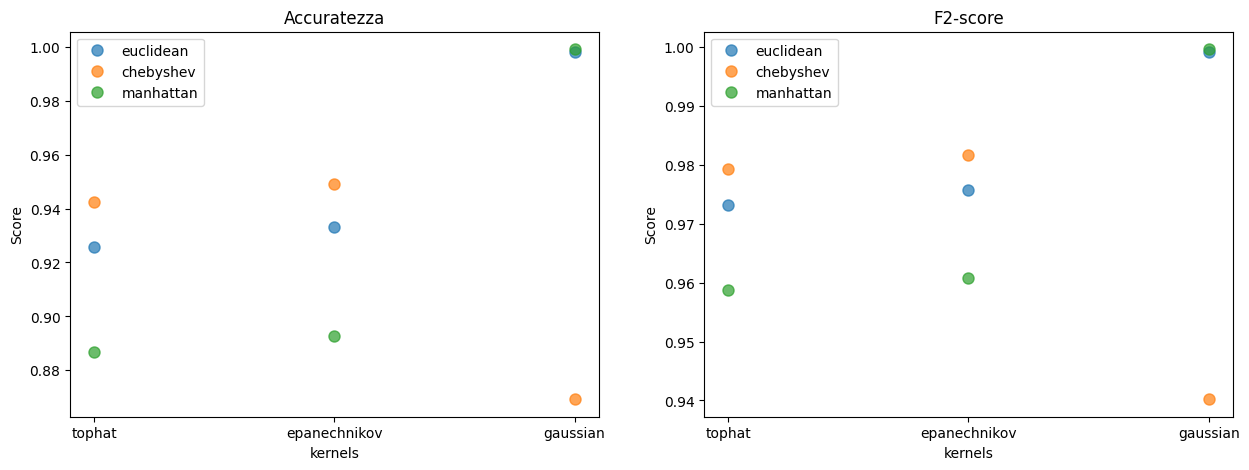

In [87]:
acc_v = []
f2_v = []

for d in dmetrics:
    acc = []
    f2 = []
    for elem in kds:
      if elem.get_dmetric() == d:
          acc.append(elem.get_acc())
          f2.append(elem.get_f2())
    acc_v.append(acc)
    f2_v.append(f2)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(0,len(dmetrics)):
    # Tracciamento del grafico
  axes[0].plot(kernels, acc_v[i], 'o', markersize=8, alpha=0.7, label=dmetrics[i])
  axes[1].plot(kernels, f2_v[i], 'o', markersize=8, alpha=0.7, label=dmetrics[i])

  axes[0].legend()
  axes[1].legend()
  axes[0].set_xlabel('kernels')
  axes[0].set_ylabel('Score')
  axes[1].set_xlabel('kernels')
  axes[1].set_ylabel('Score')

  axes[0].set_title('Accuratezza')
  axes[1].set_title('F2-score')

plt.show()

MAX f2_score:  0.9996693844055711
for kernel:  gaussian , and dmetric:  manhattan
MAX f3_score:  0.9998346648715997
for kernel:  gaussian , and dmetric:  manhattan
MAX accuracy:  0.9990830044703533
for kernel:  gaussian , and dmetric:  manhattan


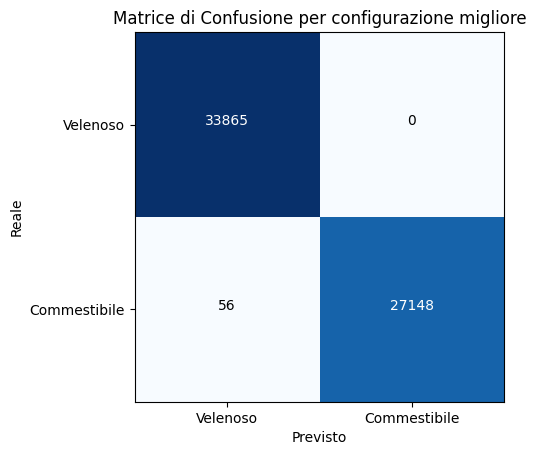

In questa configurazione abbiamo accuracy: 0.9990830044703533 e f2-score: 0.9996693844055711


In [166]:
print("MAX f2_score: ",kds_maxs[0][0])
print("for kernel: ", kds_maxs[0][1],", and dmetric: ",kds_maxs[0][2])

print("MAX f3_score: ",kds_maxs[1][0])
print("for kernel: ", kds_maxs[1][1],", and dmetric: ",kds_maxs[1][2])

print("MAX accuracy: ",kds_maxs[2][0])
print("for kernel: ", kds_maxs[2][1],", and dmetric: ",kds_maxs[2][2])
def ConfusionMatrixDisplayKds(cm, s):
  plt.imshow(cm, cmap=plt.cm.Blues)
  title = 'Matrice di Confusione per '+s
  plt.title(title)
  plt.xticks([0, 1], ['Velenoso', 'Commestibile'])
  plt.yticks([0, 1], ['Velenoso', 'Commestibile'])
  plt.xlabel('Previsto')
  plt.ylabel('Reale')
  max = 0
  for i in cm:
    for j in i:
      if j > max:
        max = j
  # Aggiunta dei valori all'interno delle celle
  thresh = max / 2.
  for i in range(0, len(cm)):
    for j in range(0, len(cm[0])):
        plt.text(j, i, cm[i][j],
                 horizontalalignment="center",
                 color="white" if cm[i][j] > thresh else "black")
for elem in kds:
  if elem.get_kernel() == kds_maxs[0][1]:
    if elem.get_dmetric() == kds_maxs[0][2]:
          ConfusionMatrixDisplayKds(elem.get_conf(), 'configurazione migliore')
          plt.show()
          print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())

### Decision Tree
Gli alberi di decisione sono classificatori che ricorsivamente vanno a partizionare lo spazio delle istanze in regioni, in accordo con qualche funzione. Alla fine, ogni foglia dell'albero è associata a una classe di predizione. Abbiamo diversi parametri di cui possiamo fare tuning, ovvero:
* la massima profondità dell'albero
* il numero minimo di elementi all'interno di una foglia
* il minimo guadagno sull'impurità di un nodo per suddivederlo in foglie/nuovi nodi
* il criterio per valutare l'impurità di un nodo

In [33]:
maxs = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
class TreeInfo:
    def __init__(self, criterion='', depth=0, min_samples_leaf=0, min_impurity_decrease=0, accuracy=0, f2=0, f3=0, conf_matrix=0):
        self.criterion = criterion
        self.depth = depth
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.accuracy = accuracy
        self.f2 = f2
        self.f3 = f3
        self.conf_matrix = conf_matrix

    def get_parametri(self):
        return [self.criterion, self.depth, self.min_samples_leaf, self.min_impurity_decrease, self.accuracy, self.f2, self.f3, self.conf_matrix]
    def get_crit(self):
        return self.criterion
    def get_depth(self):
        return self.depth
    def get_leafs(self):
        return self.min_samples_leaf
    def get_impurity(self):
        return self.min_impurity_decrease
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix

def update(target, crit, depth, leaf, impurity, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>maxs[i][0]:
      maxs[i][0] = target[i]
      maxs[i][1] = crit
      maxs[i][2] = depth
      maxs[i][3] = leaf
      maxs[i][4] = impurity
      maxs[i][5] = conf_matrix

In [34]:
#0: f2 score, 1: f3 score, 2: accuracy
x_train = df_encoded[df_encoded.columns.to_list()[1:]]
y_train = df_encoded['class']
iter = 0
size = len(x_train)
criterions = [ "gini", "entropy" ]
max_depths = [ 18,21,24,27,30,33,36,39 ]
min_samples_leafs = [1,  size//10000, size//5000]
min_impurity_decreases = [0, 0.0005, 0.001]
random_state = 90

trees = []

for crit in criterions:

  for leaf_size in min_samples_leafs:
    for imp_dec in min_impurity_decreases:
      for depth in max_depths:
          x_train = df_encoded[df_encoded.columns.to_list()[1:]]
          y_train = df_encoded['class']
          dt = DecisionTreeClassifier(criterion = crit, max_depth= depth,min_samples_leaf= leaf_size,min_impurity_decrease= imp_dec,  random_state=90)
          y_pred = cross_val_predict(estimator = dt, X=x_train, y=y_train, cv=10)
          cm = confusion_matrix(y_train, y_pred)
          accuracy = accuracy_score(y_train, y_pred)
          f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
          f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)

          update([f2_score, f3_score, accuracy], crit, depth, leaf_size, imp_dec, cm)
          currentTree = TreeInfo(crit, depth, leaf_size, imp_dec, accuracy, f2_score, f3_score, cm)
          trees.append(currentTree)
          # Calcola la media delle metriche di valutazione su tutti i fold
          iter = iter+1

print("MAX f2_score: ",maxs[0][0])
print("for criterion: ", maxs[0][1],", depth: ",maxs[0][2],", leaf_size: ",maxs[0][3],"impurity dec: ",maxs[0][4])

print("MAX f3_score: ",maxs[1][0])
print("for criterion: ", maxs[1][1],", depth: ",maxs[1][2],", leaf_size: ",maxs[1][3],"impurity dec: ",maxs[1][4])

print("MAX accuracy: ",maxs[2][0])
print("for criterion: ", maxs[2][1],", depth: ",maxs[2][2],", leaf_size: ",maxs[2][3],"impurity dec: ",maxs[2][4])


MAX f2_score:  0.9969074416161569
for criterion:  entropy , depth:  24 , leaf_size:  1 impurity dec:  0
MAX f3_score:  0.9969044998362249
for criterion:  entropy , depth:  24 , leaf_size:  1 impurity dec:  0
MAX accuracy:  0.9965776416839968
for criterion:  entropy , depth:  24 , leaf_size:  1 impurity dec:  0


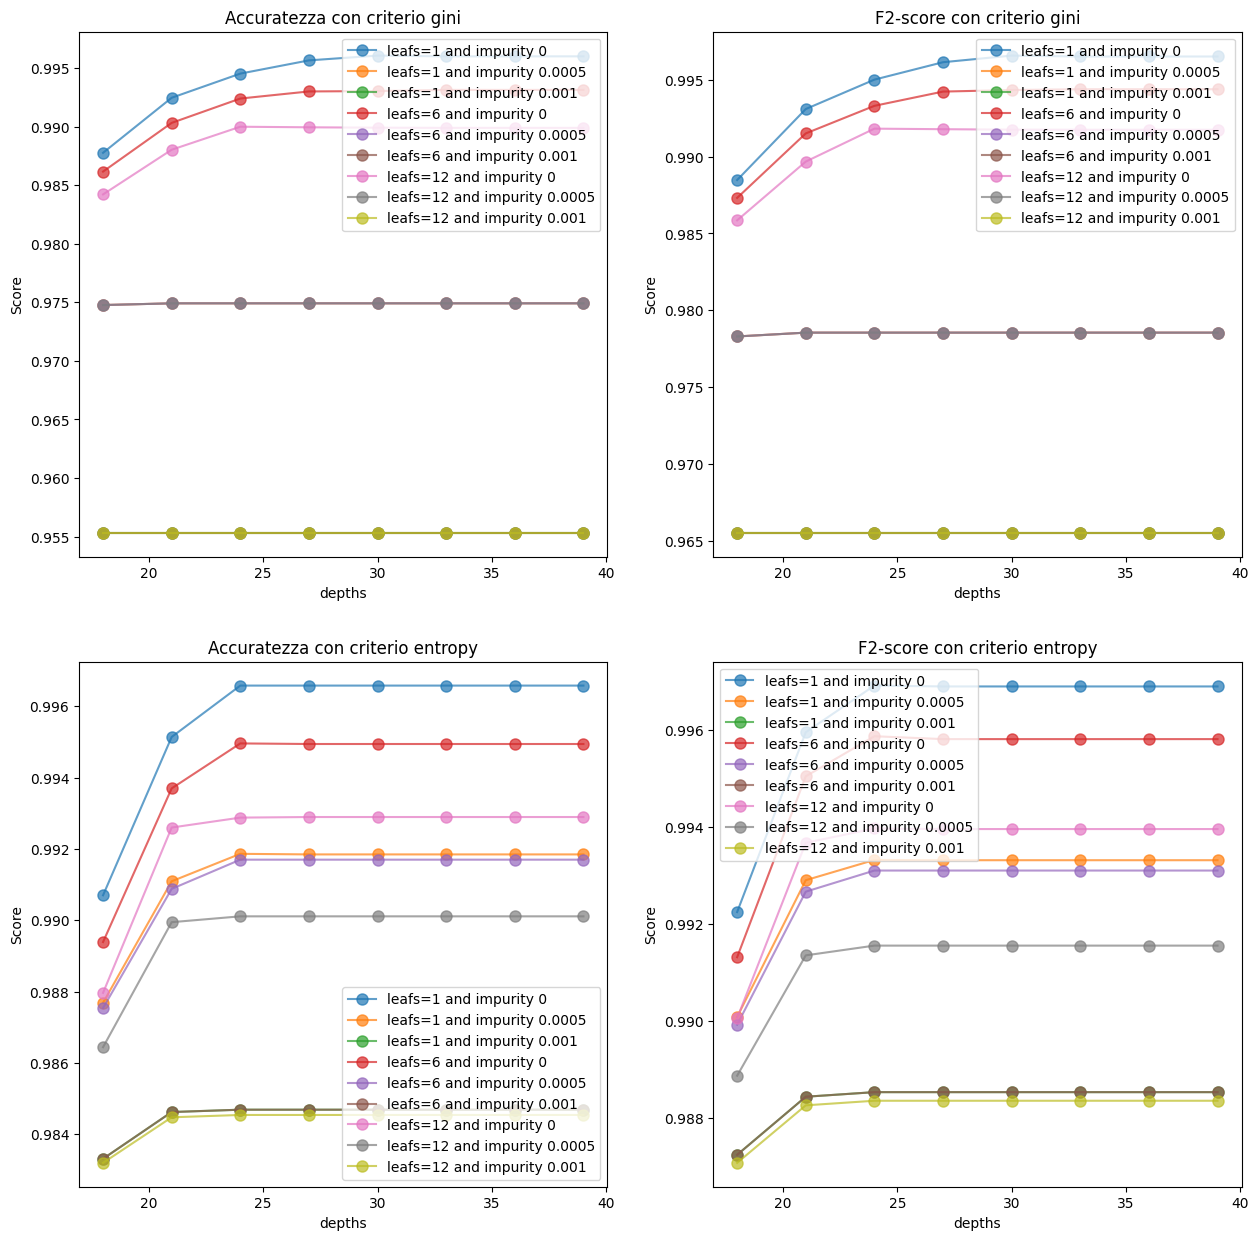

In [35]:
est_g_acc = []
est_g_f2 = []
est_e_acc = []
est_e_f2 = []
for s in min_samples_leafs:
  for t in min_impurity_decreases:
    g_acc = []
    g_f2 = []
    e_acc = []
    e_f2 = []
    for elem in trees:
      if elem.get_leafs() == s and elem.get_impurity() == t:
        if elem.get_crit() == "gini":
          g_acc.append(elem.get_acc())
          g_f2.append(elem.get_f2())
        else:
          e_acc.append(elem.get_acc())
          e_f2.append(elem.get_f2())
    est_g_f2.append(g_f2)
    est_g_acc.append(g_acc)
    est_e_acc.append(e_acc)
    est_e_f2.append(e_f2)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
l = 0
imp =0
for i in range(0,len(est_g_acc)):
    # Tracciamento del grafico
  axes[0][0].plot(max_depths, est_g_acc[i], 'o-', markersize=8, alpha=0.7, label='leafs='+str(min_samples_leafs[l])+' and impurity '+str(min_impurity_decreases[imp]))
  axes[0][1].plot(max_depths, est_g_f2[i], 'o-', markersize=8, alpha=0.7, label='leafs='+str(min_samples_leafs[l])+' and impurity '+str(min_impurity_decreases[imp]))
  axes[1][0].plot(max_depths, est_e_acc[i], 'o-', markersize=8, alpha=0.7, label='leafs='+str(min_samples_leafs[l])+' and impurity '+str(min_impurity_decreases[imp]))
  axes[1][1].plot(max_depths, est_e_f2[i], 'o-', markersize=8, alpha=0.7, label='leafs='+str(min_samples_leafs[l])+' and impurity '+str(min_impurity_decreases[imp]))
  axes[0][0].legend()
  axes[0][1].legend()
  axes[1][0].legend()
  axes[1][1].legend()
  axes[0][0].set_xlabel('depths')
  axes[0][0].set_ylabel('Score')
  axes[0][1].set_xlabel('depths')
  axes[0][1].set_ylabel('Score')
  axes[1][0].set_xlabel('depths')
  axes[1][0].set_ylabel('Score')
  axes[1][1].set_xlabel('depths')
  axes[1][1].set_ylabel('Score')

  axes[0][0].set_title('Accuratezza con criterio gini')
  axes[0][1].set_title('F2-score con criterio gini')
  axes[1][0].set_title('Accuratezza con criterio entropy')
  axes[1][1].set_title('F2-score con criterio entropy')
  if i%3 == len(min_impurity_decreases) - 1:
    l+=1
    imp=0
  else:
    imp+=1

plt.show()

Dai grafici mostrati sopra si vede chiaramente come un modello con minimo numero di elementi in una foglia 1 e minimo guadagno di impurità 0, parametri che non impongono vincoli sul partizionamento dell'albero e che logicamente potrebbero portare a un modello con overfitting, in questo particolare dataset sia la scelta migliore. Si può anche vedere come un criterio basato sull'entropia dia risultati di accuratezza ed f2-score più alti. Sempre dai grafici, possiamo vedere che con una profondità massima di 24 si raggiungono ottimi risultati, aumentando ancora la profondità non otteniamo miglioramenti. Qui sotto è mostrata la matrice di confusione in questa configuarzione ottimale.

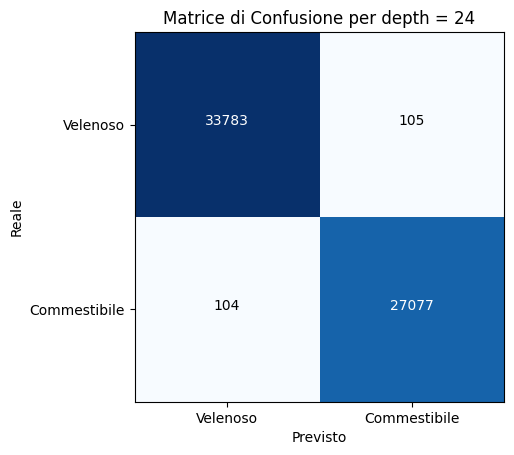

In questa configurazione abbiamo accuracy: 0.9965776416839968 e f2-score: 0.9969074416161569


In [113]:
for elem in trees:
  if elem.get_depth() == maxs[0][2]:
    if elem.get_leafs() == maxs[0][3]:
      if elem.get_crit() == maxs[0][1]:
        if elem.get_impurity() == maxs[0][4]:
          ConfusionMatrixDisplaySingle(elem.get_conf(), 'depth = '+str(elem.get_depth()))
          plt.show()
          print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())

### Random Forest
Random forest è un metodo ensamble che prende diversi alberi decisionali e fa la sua predizione andando a valutare la predizione maggioritaria tra tutti gli alberi (bagging). In questo modello abbiamo diversi parametri di cui possiamo fare tuning:
* la massima profondità per ogni albero
* il numero di alberi selezionati
* il criterio con cui viene valutata l'omogeneità di un nodo durantre lo splitting

In [115]:
forest_maxs=[[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
class RandomInfo:
    def __init__(self,cm, criterion='', depth=0, n_estimators=0, accuracy=0, f2=0, f3=0):
        self.criterion = criterion
        self.depth = depth
        self.n_estimators = n_estimators
        self.accuracy = accuracy
        self.f2 = f2
        self.f3 = f3
        self.cm=cm
    def get_parametri(self):
        return [self.criterion, self.depth, self.n_estimators, self.accuracy, self.f2, self.f3, self.cm]
    def get_depth(self):
      return self.depth
    def get_n_est(self):
      return self.n_estimators
    def get_acc(self):
      return self.accuracy
    def get_f2(self):
      return self.f2
    def get_cm(self):
      return self.cm
    def get_crit(self):
      return self.criterion

def update(target, crit, depth, n_estimators, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>forest_maxs[i][0]:
      forest_maxs[i][0] = target[i]
      forest_maxs[i][1] = crit
      forest_maxs[i][2] = depth
      forest_maxs[i][3] = n_estimators
      forest_maxs[i][4] = conf_matrix


In [116]:
x_train = df_encoded[df_encoded.columns.to_list()[1:]]
y_train = df_encoded['class']
max_depths = [2,3,4,5,6,7,8]
criterions = [ "gini", "entropy" ]
n_estimators = [10, 50, 100]
forest_info=[]

for crit in criterions:
  for estimators in n_estimators:
    for depth in max_depths:
      rf = RandomForestClassifier(criterion = crit, n_estimators= estimators, max_depth= depth)
      y_pred = cross_val_predict(rf, x_train, y_train, cv=10)
      accuracy = accuracy_score(y_train, y_pred)
      f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
      f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)
      cm=confusion_matrix(y_train, y_pred)
      tree = RandomInfo(cm, crit, depth, estimators, accuracy, f2_score, f3_score)
      forest_info.append(tree)
      update([f2_score,f3_score,accuracy],crit,estimators,depth,cm)

Come si può vedere dai grafici qui sotto, indifferentemente dal numero di stimatori considerato e dal criterio considerato, all'aumentare della profondità degli alberi sia accuratezza che f2-score tendono a migliorare.



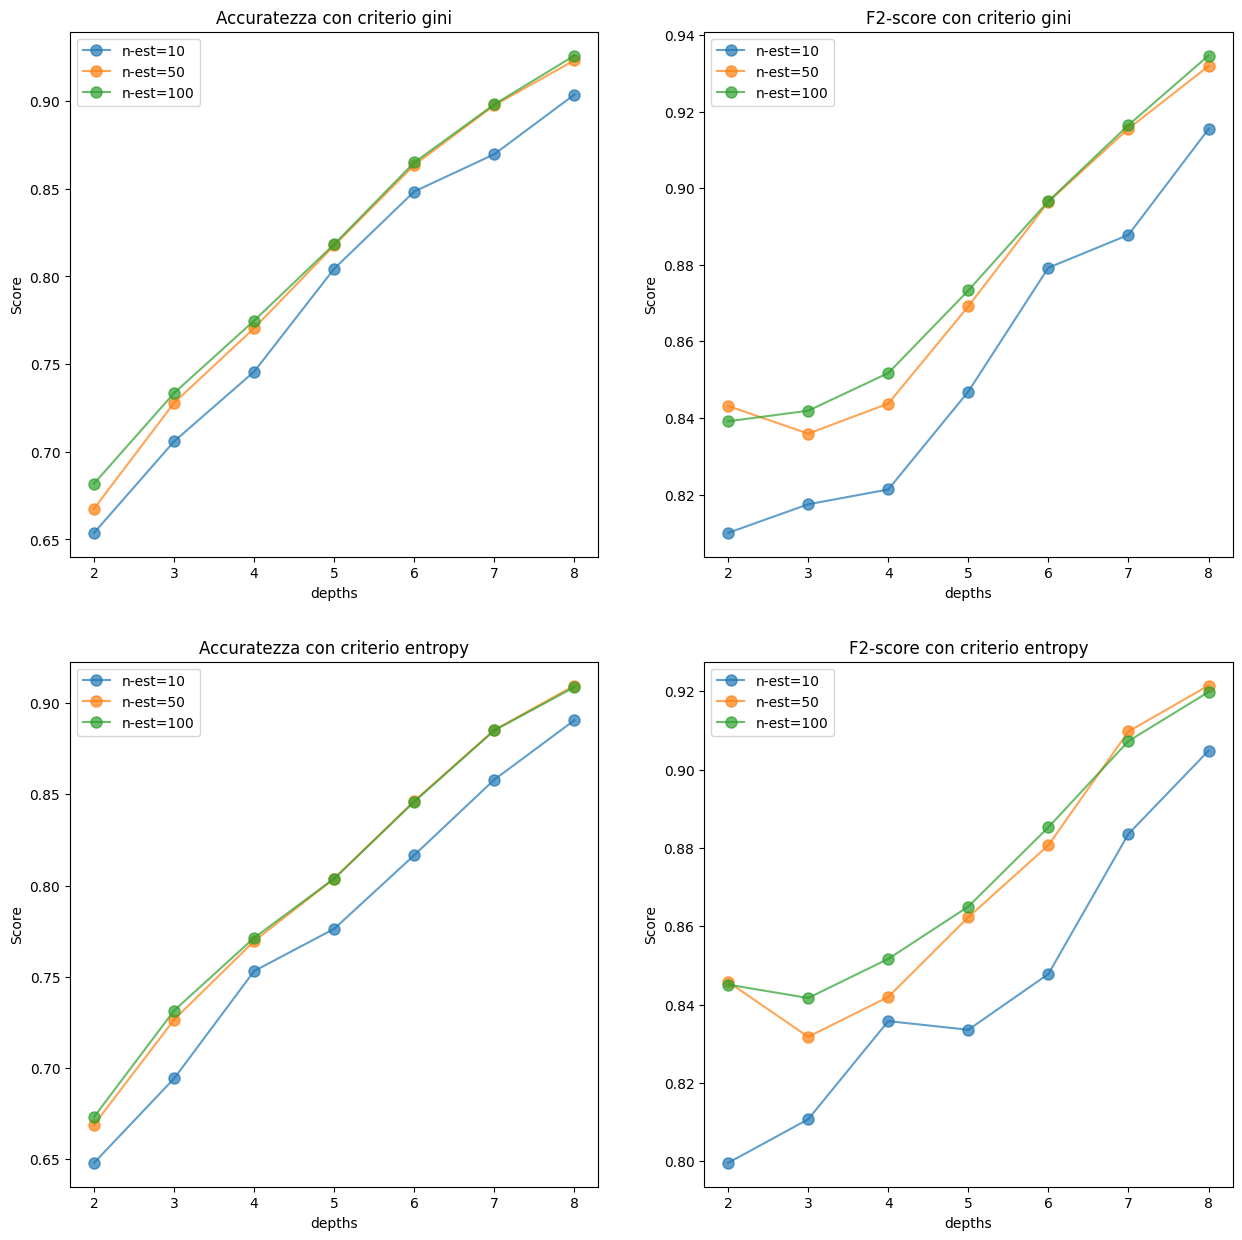

In [117]:
est_g_acc = []
est_g_f2 = []
est_e_acc = []
est_e_f2 = []
for s in n_estimators:
  g_acc = []
  g_f2 = []
  e_acc = []
  e_f2 = []
  for elem in forest_info:
    if elem.get_n_est() == s:
      if elem.get_crit() == "gini":
        g_acc.append(elem.get_acc())
        g_f2.append(elem.get_f2())
      else:
        e_acc.append(elem.get_acc())
        e_f2.append(elem.get_f2())
  est_g_f2.append(g_f2)
  est_g_acc.append(g_acc)
  est_e_acc.append(e_acc)
  est_e_f2.append(e_f2)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i in range(0,len(est_g_acc)):
    # Tracciamento del grafico

  axes[0][0].plot(max_depths, est_g_acc[i], 'o-', markersize=8, alpha=0.7, label='n-est='+str(n_estimators[i]))
  axes[0][1].plot(max_depths, est_g_f2[i], 'o-', markersize=8, alpha=0.7, label='n-est='+str(n_estimators[i]))
  axes[1][0].plot(max_depths, est_e_acc[i], 'o-', markersize=8, alpha=0.7, label='n-est='+str(n_estimators[i]))
  axes[1][1].plot(max_depths, est_e_f2[i], 'o-', markersize=8, alpha=0.7, label='n-est='+str(n_estimators[i]))
  axes[0][0].legend()
  axes[0][1].legend()
  axes[1][0].legend()
  axes[1][1].legend()
  axes[0][0].set_xlabel('depths')
  axes[0][0].set_ylabel('Score')
  axes[0][1].set_xlabel('depths')
  axes[0][1].set_ylabel('Score')
  axes[1][0].set_xlabel('depths')
  axes[1][0].set_ylabel('Score')
  axes[1][1].set_xlabel('depths')
  axes[1][1].set_ylabel('Score')

  axes[0][0].set_title('Accuratezza con criterio gini')
  axes[0][1].set_title('F2-score con criterio gini')
  axes[1][0].set_title('Accuratezza con criterio entropy')
  axes[1][1].set_title('F2-score con criterio entropy')
plt.show()


Dal grafico sottostante, che mostra come variano accuratezza ed f2-score al variare del numero di stimatori, si può vedere come il criterio gini per l'omogeneità dei nodi dia risultati migliori, e come con 50 stimatori si raggiunge un buon livello di accuratezza, aumentare ancora non porta miglioramenti, porta anche una leggera diminuzione.

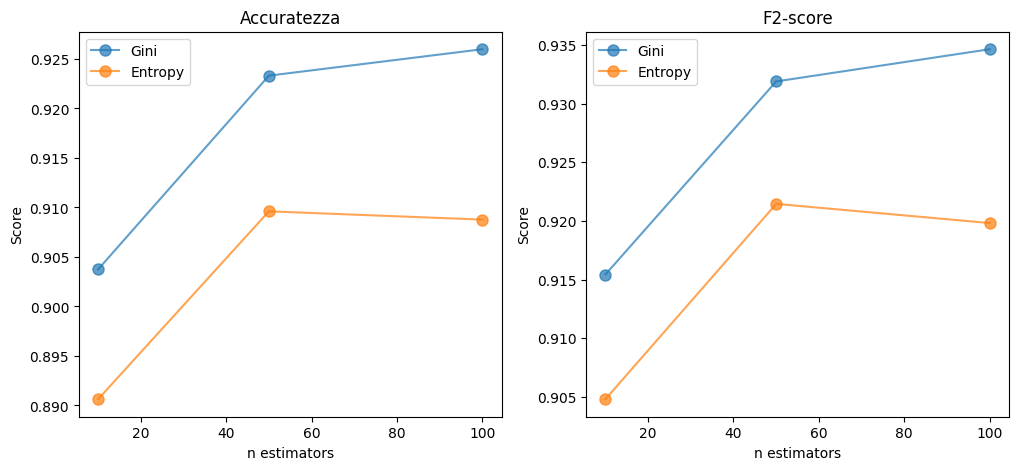

In [118]:
g_acc = []
g_f2 = []
e_acc = []
e_f2 = []
for elem in forest_info:
  if elem.get_depth() == 8:
    if elem.get_crit() == "gini":
      g_acc.append(elem.get_acc())
      g_f2.append(elem.get_f2())
    else:
      e_acc.append(elem.get_acc())
      e_f2.append(elem.get_f2())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(n_estimators, g_acc, 'o-', markersize=8, alpha=0.7, label='Gini')
axes[0].plot(n_estimators, e_acc, 'o-', markersize=8, alpha=0.7, label='Entropy')
axes[1].plot(n_estimators, g_f2, 'o-', markersize=8, alpha=0.7, label='Gini')
axes[1].plot(n_estimators, e_f2, 'o-', markersize=8, alpha=0.7, label='Entropy')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('n estimators')
axes[0].set_ylabel('Score')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('Score')

axes[0].set_title('Accuratezza')
axes[1].set_title('F2-score')
plt.show()


Nella configurazione migliore, ovvero critetio gini, profondità 8 e cinquanta stimatori, la matrice di confusione è la seguente.
Con questa configurazione le predizioni siano molto buone.

MAX f2_score:  0.9346400603830549
for criterion:  gini , depth:  8 , number of estimators:  100
MAX f3_score:  0.935037047524659
for criterion:  gini , depth:  8 , number of estimators:  100
MAX accuracy:  0.925985360821366
for criterion:  gini , depth:  8 , number of estimators:  100


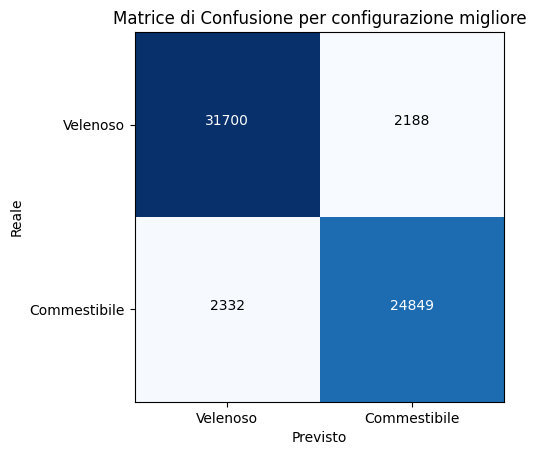

In questa configurazione abbiamo accuracy: 0.925985360821366 e f2-score: 0.9346400603830549


In [119]:
print("MAX f2_score: ",forest_maxs[0][0])
print("for criterion: ", forest_maxs[0][1],", depth: ",forest_maxs[0][3],", number of estimators: ",forest_maxs[0][2])

print("MAX f3_score: ",forest_maxs[1][0])
print("for criterion: ", forest_maxs[1][1],", depth: ",forest_maxs[1][3],", number of estimators: ",forest_maxs[1][2])

print("MAX accuracy: ",forest_maxs[2][0])
print("for criterion: ", forest_maxs[2][1],", depth: ",forest_maxs[2][3],", number of estimators: ",forest_maxs[2][2])
for elem in forest_info:
  if elem.get_depth() == forest_maxs[0][3]:
    if elem.get_n_est() == forest_maxs[0][2]:
      if elem.get_crit() == forest_maxs[0][1]:
        ConfusionMatrixDisplaySingle(elem.get_cm(), 'configurazione migliore')
        plt.show()
        print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())

### SVM


Anche questo metodo cerca di separare le classi in due regioni di spazio distinte andando a massimizzare il margine (ovvero lo spazio tra l'iperpiano separatore e l'elemento di una classe più vicino al piano stesso). Nel nostro modello prendiamo in considerazione pesi diversi per aggiungere una penalizzazione alla funzione di loss, e variamo anche il numero di interazioni nel processo di discesa del gradiente.

In [120]:
##due classificatori diversi perché il primo è ottimizzato per SVM lineare con solo un iperpiano di separazione
##f loss standard: hinge loss

#dual: dice se risolvere il problema duale o primale
#C: parametro di regolarizzazione
#max_iter: numero di iterazioni massimo da eseguire
#random_state: sempre il random seed
svm_maxs = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]

class SVCInfo:
    def __init__(self, C=0, max_iter=0, accuracy=0, f2=0, f3=0, conf_matrix=0):
        self.C = C
        self.max_iter = max_iter
        self.accuracy = accuracy
        self.f2 = f2
        self.f3 = f3
        self.conf_matrix = conf_matrix

    def get_parametri(self):
        return [ self.C, self.max_iter, self.accuracy, self.f2, self.f3, self.conf_matrix]
    def get_C(self):
        return self.C
    def get_max_iter(self):
        return self.max_iter
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix

def update(target, C, max_iters, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>svm_maxs[i][0]:
      svm_maxs[i][0] = target[i]
      svm_maxs[i][1] = C
      svm_maxs[i][2] = max_iters
      svm_maxs[i][3] = conf_matrix




In [121]:
SVCs = []
iter = 0

#teniamo solo il primale che è più veloce e per di più
Cs = [0.1, 0.2,0.5,0.75,1,2]
max_iters = [10, 100, 1000, 2500]
a_random_state = 63
for a_C in Cs:
  for a_max_iter in max_iters:


      x_train = df_encoded[df_encoded.columns.to_list()[1:]]
      y_train = df_encoded['class']

      lsvm = LinearSVC(dual = False, C=a_C, max_iter = a_max_iter, random_state = a_random_state)

      y_pred = cross_val_predict(estimator = lsvm, X=x_train, y=y_train, cv=10)
      cm = confusion_matrix(y_train, y_pred)
      accuracy = accuracy_score(y_train, y_pred)
      f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
      f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)

      update([f2_score, f3_score, accuracy], a_C, a_max_iter, cm)
      currentSVC = SVCInfo( a_C, a_max_iter, accuracy, f2_score, f3_score, confusion_matrix(y_train, y_pred))
      SVCs.append(currentSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

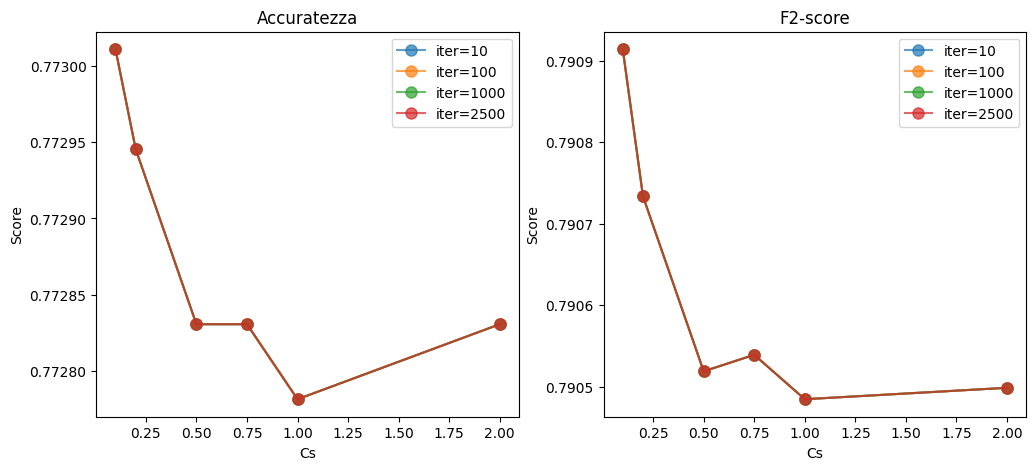

In [122]:
acc_v = []
f2_v = []
for i in max_iters:
  acc = []
  f2 = []
  for elem in SVCs:
    if elem.get_max_iter() == i:
      acc.append(elem.get_acc())
      f2.append(elem.get_f2())
  acc_v.append(acc)
  f2_v.append(f2)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(0, len(max_iters)):
  axes[0].plot(Cs, acc_v[i], 'o-', markersize=8, alpha=0.7, label='iter='+str(max_iters[i]))
  axes[1].plot(Cs, f2_v[i], 'o-', markersize=8, alpha=0.7, label='iter='+str(max_iters[i]))
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('Cs')
axes[0].set_ylabel('Score')
axes[1].set_xlabel('Cs')
axes[1].set_ylabel('Score')

axes[0].set_title('Accuratezza')
axes[1].set_title('F2-score')
plt.show()


Come si può vedere, diminuire  il peso della penalità sulla loss porta un peggioramento, indifferentemente dal numero di iterazioni considerato. La configurazione migliore si ha per la C minore possibile.

MAX f2_score:  0.7909141477501361
for c:  0.1 , max iters:  10
MAX f3_score:  0.7898578131833064
for c:  0.1 , max iters:  10
MAX accuracy:  0.7730108565720742
for c:  0.1 , max iters:  10


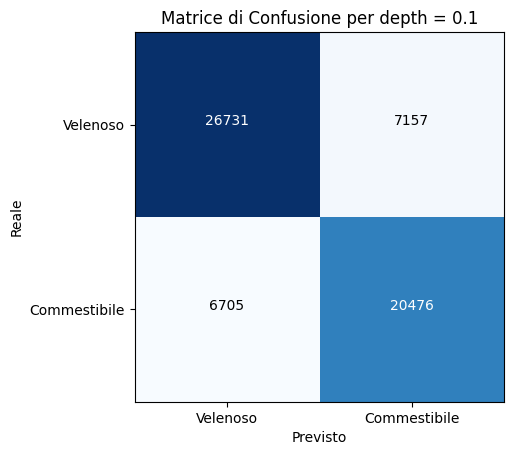

In questa configurazione abbiamo accuracy: 0.7730108565720742 e f2-score: 0.7909141477501361


In [130]:
print("MAX f2_score: ",svm_maxs[0][0])
print("for c: ",svm_maxs[0][1],", max iters: ",svm_maxs[0][2])

print("MAX f3_score: ",svm_maxs[1][0])
print("for c: ",svm_maxs[1][1],", max iters: ",svm_maxs[1][2])

print("MAX accuracy: ",svm_maxs[2][0])
print("for c: ",svm_maxs[2][1],", max iters: ",svm_maxs[2][2])

for elem in SVCs:
  if elem.get_max_iter() == svm_maxs[0][2]:
    if elem.get_C() == svm_maxs[0][1]:
          ConfusionMatrixDisplaySingle(elem.get_conf(), 'depth = '+str(elem.get_C()))
          plt.show()
          print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())

### SVM con funzione Kernel
In questa variante di SVM si usa una funzione kernel per valutare la distanza tra due punti, proiettandoli in uno spazio di dimensioni maggiori in cui si tenta di renderli linearmente separabili. Anche qui abbiamo il peso della funzione di penalità che varia, in più testiamo il modello con diverse funzioni kernel e con due valori per il massimo numero di iterazioni. Non abbiamo fatto aumentare ancora il numero di iterazioni per motivi di tempo.

In [124]:
k_maxs = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
class k_SVCInfo:
    def __init__(self, kernel='', C=0, max_iter=0, accuracy=0, f2=0, f3=0, conf_matrix=0):
        self.kernel = kernel
        self.C = C
        self.max_iter=max_iter
        self.accuracy = accuracy
        self.f2 = f2
        self.f3 = f3
        self.conf_matrix = conf_matrix

    def get_parametri(self):
        return [  self.kernel, self.C, self.accuracy, self.max_iter, self.f2, self.f3, self.conf_matrix]
    def get_kernel(self):
        return self.kernel
    def get_C(self):
        return self.C
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix
    def get_iter(self):
        return self.max_iter

def update(target, kernel, C, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>k_maxs[i][0]:
      k_maxs[i][0] = target[i]
      k_maxs[i][1] = kernel
      k_maxs[i][2] = C
      k_maxs[i][3] = conf_matrix

In [125]:
Cs = [0.1, 0.2,0.5,0.75,1,2]
kernels = ['poly', 'sigmoid', 'rbf' ]
k_SVCs = []
iter = 0
max_iter = [100,200]

for i in max_iter:
  for kernel in kernels:
    for C in Cs:

      x_train = df_encoded[df_encoded.columns.to_list()[1:]]
      y_train = df_encoded['class']

      #degree ignored for kernel != poly
      k_SVC = SVC(kernel = kernel, degree = 2, C = C, max_iter=i )
      y_pred = cross_val_predict(estimator = k_SVC, X=x_train, y=y_train, cv=10)
      cm = confusion_matrix(y_train, y_pred)
      accuracy = accuracy_score(y_train, y_pred)
      f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
      f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)

      update([f2_score, f3_score, accuracy], kernel, C, cm)
      curr_kSVC = k_SVCInfo( kernel, C, i, accuracy, f2_score, f3_score, confusion_matrix(y_train, y_pred))
      k_SVCs.append(curr_kSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

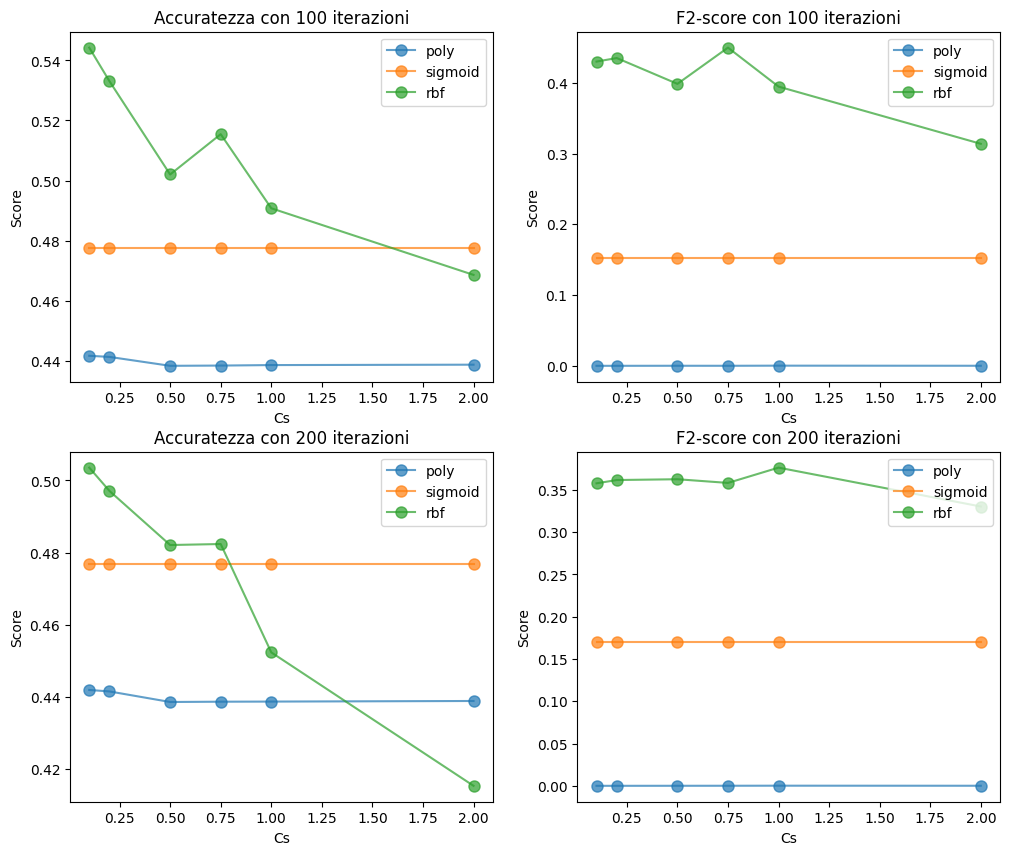

In [126]:
acc_v_1 = []
acc_v_2 = []
f2_v_1 = []
f2_v_2 = []
for i in kernels:
  acc_1 = []
  f2_1 = []
  acc_2 = []
  f2_2 = []

  for elem in k_SVCs:
    if elem.get_kernel() == i:
      if elem.get_iter() == 100:
        acc_1.append(elem.get_acc())
        f2_1.append(elem.get_f2())
      else:
        acc_2.append(elem.get_acc())
        f2_2.append(elem.get_f2())
  acc_v_1.append(acc_1)
  f2_v_1.append(f2_1)
  acc_v_2.append(acc_2)
  f2_v_2.append(f2_2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i in range(0, len(kernels)):
  axes[0][0].plot(Cs, acc_v_1[i], 'o-', markersize=8, alpha=0.7, label=kernels[i])
  axes[0][1].plot(Cs, f2_v_1[i], 'o-', markersize=8, alpha=0.7, label=kernels[i])
  axes[1][0].plot(Cs, acc_v_2[i], 'o-', markersize=8, alpha=0.7, label=kernels[i])
  axes[1][1].plot(Cs, f2_v_2[i], 'o-', markersize=8, alpha=0.7, label=kernels[i])
axes[0][0].legend()
axes[0][1].legend()
axes[1][0].legend()
axes[1][1].legend()
axes[0][0].set_xlabel('Cs')
axes[0][0].set_ylabel('Score')
axes[0][1].set_xlabel('Cs')
axes[0][1].set_ylabel('Score')
axes[1][0].set_xlabel('Cs')
axes[1][0].set_ylabel('Score')
axes[1][1].set_xlabel('Cs')
axes[1][1].set_ylabel('Score')

axes[0][0].set_title('Accuratezza con 100 iterazioni')
axes[0][1].set_title('F2-score con 100 iterazioni')
axes[1][0].set_title('Accuratezza con 200 iterazioni')
axes[1][1].set_title('F2-score con 200 iterazioni')
plt.show()

MAX f2_score:  0.4499450219912035
for kernel:  rbf , c:  0.75
MAX f3_score:  0.4371418859862096
for kernel:  rbf , c:  0.75
MAX accuracy:  0.5442532217655439
for kernel:  rbf , c:  0.1
Con algoritmo: rbf 100 iterazioni e penalità:  0.1 abbiamo accuracy: 0.5442532217655439 e f2-score: 0.4302099583152188
Con algoritmo: rbf 100 iterazioni e penalità:  0.75 abbiamo accuracy: 0.5154333622623589 e f2-score: 0.4499450219912035
Con algoritmo: rbf 200 iterazioni e penalità:  0.1 abbiamo accuracy: 0.5035615451374674 e f2-score: 0.35774342459794445
Con algoritmo: rbf 200 iterazioni e penalità:  0.75 abbiamo accuracy: 0.4823560235143854 e f2-score: 0.3582356268641366


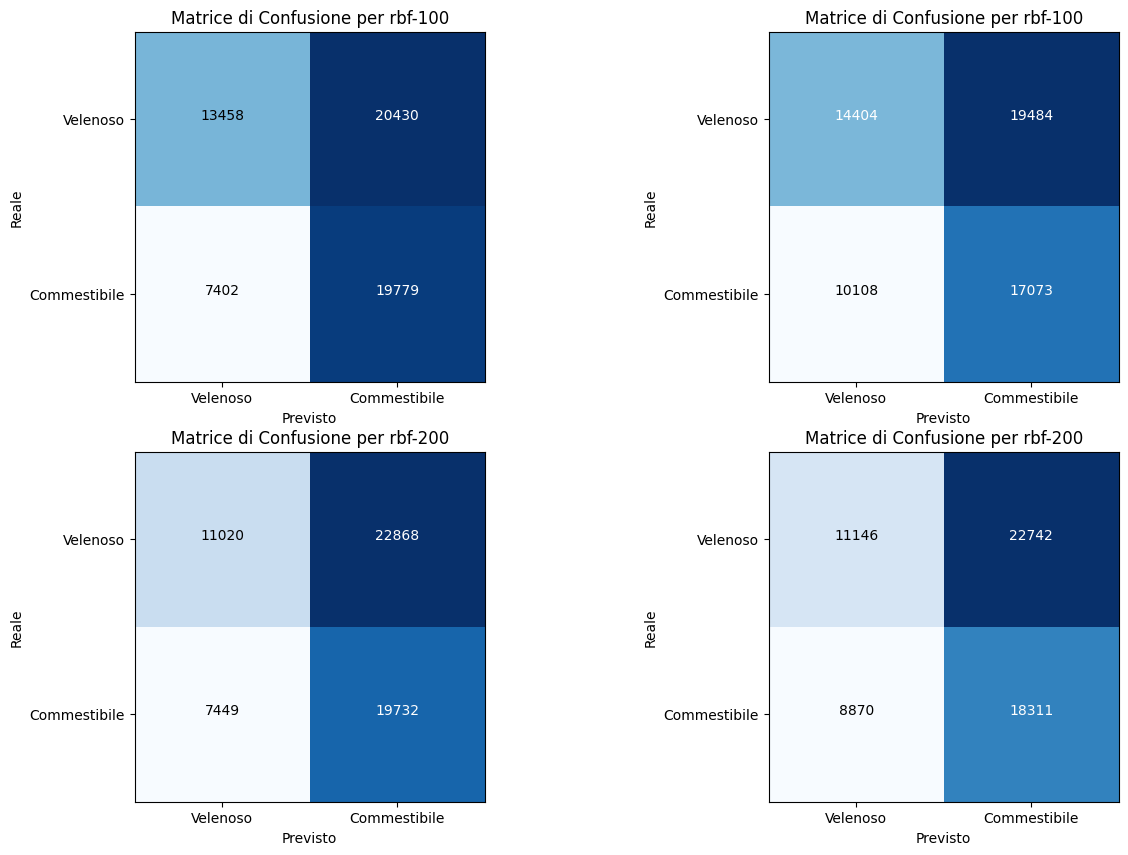

In [174]:
print("MAX f2_score: ",k_maxs[0][0])
print("for kernel: ", k_maxs[0][1],", c: ",k_maxs[0][2])

print("MAX f3_score: ",k_maxs[1][0])
print("for kernel: ", k_maxs[1][1],", c: ",k_maxs[1][2])

print("MAX accuracy: ",k_maxs[2][0])
print("for kernel: ", k_maxs[2][1],", c: ",k_maxs[2][2])
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
y = 0
x = 0
for elem in k_SVCs:
  if elem.get_kernel() == 'rbf':
    if elem.get_C() == 0.1 or elem.get_C() == 0.75:
          ConfusionMatrixDisplay(elem.get_conf(), y, axes[x], elem.get_kernel()+'-'+str(elem.get_iter()))
          if y == 1:
            x+=1
            y=0
          else:
            y+=1
          print("Con algoritmo:", elem.get_kernel(), elem.get_iter(), "iterazioni e penalità: ", elem.get_C(), "abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())
plt.show()

Sui risultati non c'è molto da dire, sono incredibilmente bassi e anche il miglior modello ottenuto con questo algoritmo di classificazione è da scartare.

Il training dei modelli, indipendenemtente dall'utilizzo di un kernel o meno, non convergono in una quantità di tempo ragionevole e anche aumentando il numero di iterazioni ad un valore maggiore ma comunque finito (che porta a un costo eccessivamente elevato in termini di tempo per il training), il guadagno in termini di prestazioni è irrisorio: per motivi di praticità si è evitato di mantenerli nel codice.

### Multilayer Perceptron
Questo classificatore è formato da diversi percettroni che trasferiscono i risultati da uno all'altro tramite una funzione di attivazione. Ci sono diversi tipi di funzione di attivazione possibili. Abbiamo la possibilità di variare il numero e la dimensione di hidden layers.

In [128]:
mlpc_maxs = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
class mlpcInfo:
    def __init__(self, activation='', h_layers=0,accuracy=0, f2=0, f3=0, conf_matrix=0):
        self.h_layers = h_layers
        self.activation = activation
        self.accuracy=accuracy
        self.f2 = f2
        self.f3 = f3
        self.conf_matrix = conf_matrix

    def get_parametri(self):
        return [  self.activation, self.h_layers, self.accuracy, self.f2, self.f3, self.conf_matrix]
    def get_h_layers(self):
        return self.h_layers
    def get_activation(self):
        return self.activation
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix

def update(target, activation, h_layers, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>mlpc_maxs[i][0]:
      mlpc_maxs[i][0] = target[i]
      mlpc_maxs[i][1] = activation
      mlpc_maxs[i][2] = h_layers
      mlpc_maxs[i][3] = conf_matrix

In [129]:
hidden_layers = [[10], [100], [10,10], [100,10], [100,100], [150,150], [100,100,100]]
activations = ['identity', 'logistic', 'tanh', 'relu']
mlpcs = []
iter = 0
random_state = 87
for activ in activations:
  for layers in hidden_layers:

        x_train = df_encoded[df_encoded.columns.to_list()[1:]]
        y_train = df_encoded['class']

        #variazione performance poco significativa con l'aumento di max iter (mentre il tempo aumenta non linearmente)
        mlpc = MLPClassifier(activation = activ, hidden_layer_sizes = layers, batch_size = 2500, max_iter = 15, random_state = random_state)
        y_pred = cross_val_predict(estimator = mlpc, X=x_train, y=y_train, cv=10)
        cm = confusion_matrix(y_train, y_pred)
        accuracy = accuracy_score(y_train, y_pred)
        f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
        f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)

        update([f2_score, f3_score, accuracy], activ, layers, cm)
        curr_mlpc = mlpcInfo( activ, layers, accuracy, f2_score, f3_score, cm)
        mlpcs.append(curr_mlpc)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

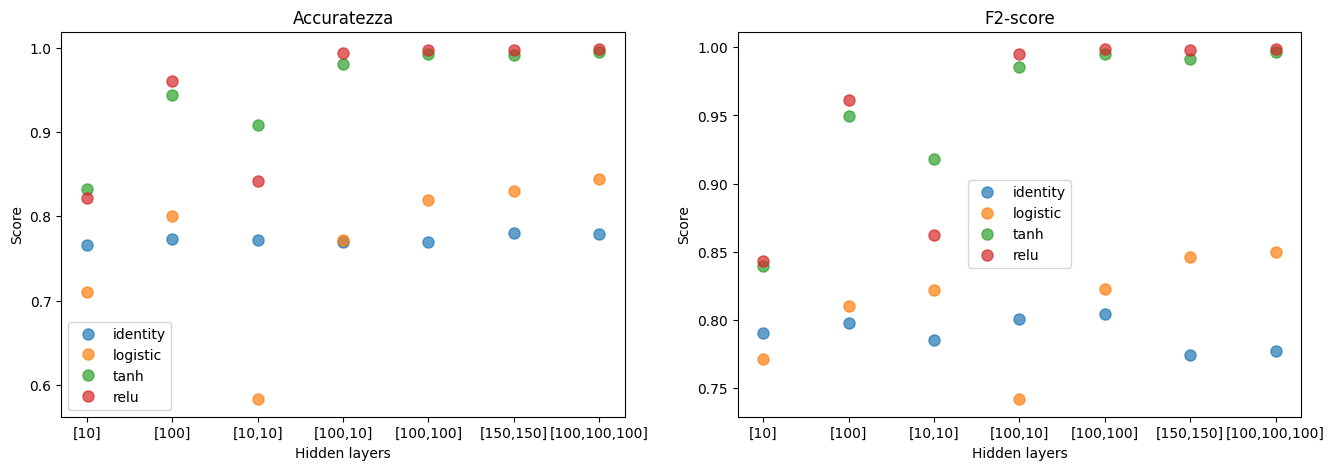

In [131]:
acc_v = []
f2_v = []
n_hidden_layers = ['[10]', '[100]', '[10,10]', '[100,10]', '[100,100]', '[150,150]', '[100,100,100]']
for a in activations:
  acc = []
  f2 = []
  for elem in mlpcs:
    if elem.get_activation()==a:
      acc.append(elem.get_acc())
      f2.append(elem.get_f2())
  acc_v.append(acc)
  f2_v.append(f2)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for i in range(0, len(activations)):
  axes[0].plot(n_hidden_layers, acc_v[i], 'o', markersize=8, alpha=0.7, label=activations[i])
  axes[1].plot(n_hidden_layers, f2_v[i], 'o', markersize=8, alpha=0.7, label=activations[i])
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('Hidden layers')
axes[0].set_ylabel('Score')
axes[1].set_xlabel('Hidden layers')
axes[1].set_ylabel('Score')

axes[0].set_title('Accuratezza')
axes[1].set_title('F2-score')
plt.show()

Come si può vedere dai grafici, i risultati migliori, che sono molto alti rispetto anche ad altri algoritmi usati, si hanno per la funzione di attivazione 'relu', ovvero una funzione che dà zero per valori negativi e l'identità per valori positivi. Il numero migliore di hidden layers da usare è diverso se consideriamo f2-score o accuracy, infatti avere due layers è meglio nel primo caso, tre è meglio nel secondo. Le metriche tendono a migliorare di più aumentando il numero di layers piuttosto che la loro dimensione.

MAX f2_score:  0.9986077599683794
for activations:  relu , and hidden layers:  [100, 100]
MAX f3_score:  0.9988169381415011
for activations:  relu , and hidden layers:  [100, 100]
MAX accuracy:  0.9981332591003619
for activations:  relu , and hidden layers:  [100, 100, 100]


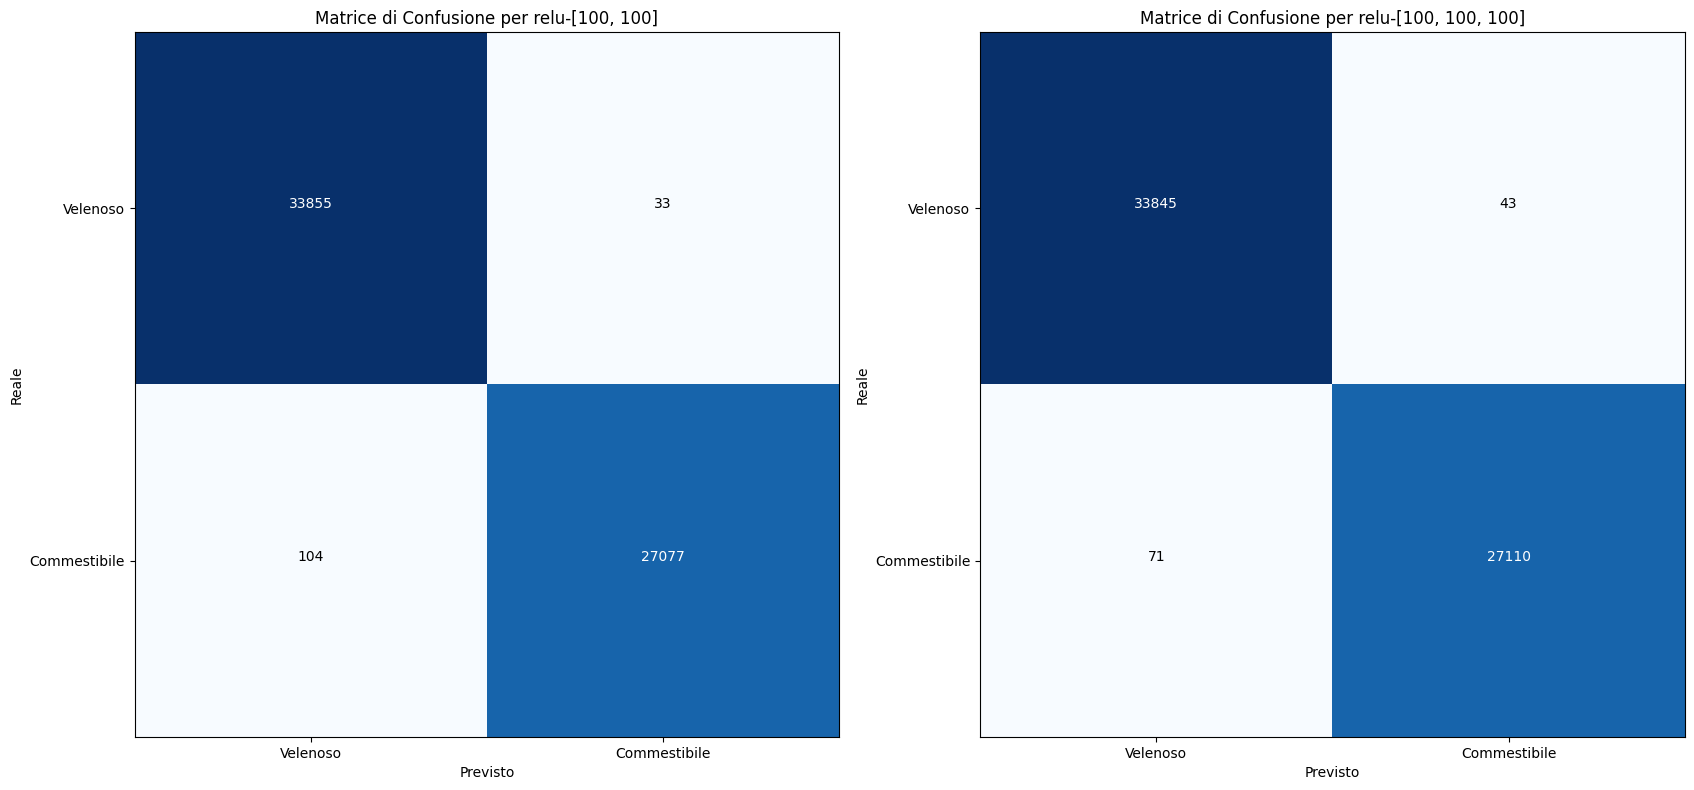

In [134]:
print("MAX f2_score: ",mlpc_maxs[0][0])
print("for activations: ", mlpc_maxs[0][1],", and hidden layers: ",mlpc_maxs[0][2])

print("MAX f3_score: ",mlpc_maxs[1][0])
print("for activations: ", mlpc_maxs[1][1],", and hidden layers: ",mlpc_maxs[1][2])

print("MAX accuracy: ",mlpc_maxs[2][0])
print("for activations: ", mlpc_maxs[2][1],", and hidden layers: ",mlpc_maxs[2][2])
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
y = 0
for elem in mlpcs:
  if elem.get_activation() == 'relu':
    if elem.get_h_layers() == [100,100] or elem.get_h_layers()==[100,100,100]:
          ConfusionMatrixDisplay(elem.get_conf(), y, axes, elem.get_activation()+'-'+str(elem.get_h_layers()))
          y+=1
plt.show()

### Adaboost
Questo è un altro classificatore che usa un metodo ensamble, quindi va ad unire i risultati di un certo numero di classificatori dello stesso tipo. In particolare, usa la tecnica del boosting in cui ogni classificatore cerca di correggere la predizione del precedente assegnando un peso diverso agli elementi del dataset. La predizione finale è basata su quella di ciascun classificatore, combinandoli assegnando a ciascuno un valore di confidenza. Possiamo far variare il numero e il tipo di predittori presi in considerazione.

In [135]:
ada_maxs = [[0,0,0,0],[0,0,0,0],[0,0,0,0]]
class adaInfo:
    def __init__(self, alg='',n=0,accuracy=0, f2=0, f3=0, conf_matrix=0):
        self.alg = alg
        self.n = n
        self.accuracy=accuracy
        self.f2 = f2
        self.f3 = f3
        self.conf_matrix = conf_matrix

    def get_parametri(self):
        return [  self.alg, self.accuracy, self.f2, self.f3, self.conf_matrix]
    def get_alg(self):
        return self.alg
    def get_n_est(self):
        return self.n
    def get_acc(self):
        return self.accuracy
    def get_f2(self):
        return self.f2
    def get_f3(self):
        return self.f3
    def get_conf(self):
        return self.conf_matrix

def update(target, layers, alg, conf_matrix):
  for i in range(0,len(target)):
    if target[i]>ada_maxs[i][0]:
      ada_maxs[i][0] = target[i]
      ada_maxs[i][1] = layers
      ada_maxs[i][2] = alg
      ada_maxs[i][3] = conf_matrix

In [136]:
n_estimators = [10, 50, 150]

adas = []
iter = 0
random_state = 40

nb = GaussianNB()
logreg = LogisticRegression(penalty='l2', C=0.1, solver='newton-cholesky', max_iter=1000)
dt1 = DecisionTreeClassifier(max_depth= 2, random_state=random_state)
dt2 = DecisionTreeClassifier(max_depth= 4, random_state=random_state)

estimators = {
    'tree 1' : dt1,
    'tree 2' : dt2,
    'naive bayes' : nb,
    'logistic regressor' : logreg
}

for est in estimators:
  for n in n_estimators:
    x_train = df_encoded[df_encoded.columns.to_list()[1:]]
    y_train = df_encoded['class']
    adaboost = AdaBoostClassifier(estimator=estimators[est], n_estimators=n, random_state=random_state)

    y_pred = cross_val_predict(estimator = adaboost, X=x_train, y=y_train, cv=10)
    cm = confusion_matrix(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f2_score = fbeta_score(y_train, y_pred, beta=2, pos_label=0)
    f3_score = fbeta_score(y_train, y_pred, beta=3, pos_label=0)

    update([f2_score, f3_score, accuracy],n, est, cm)
    curr_ada = adaInfo( est,n, accuracy, f2_score, f3_score, cm)
    adas.append(curr_ada)

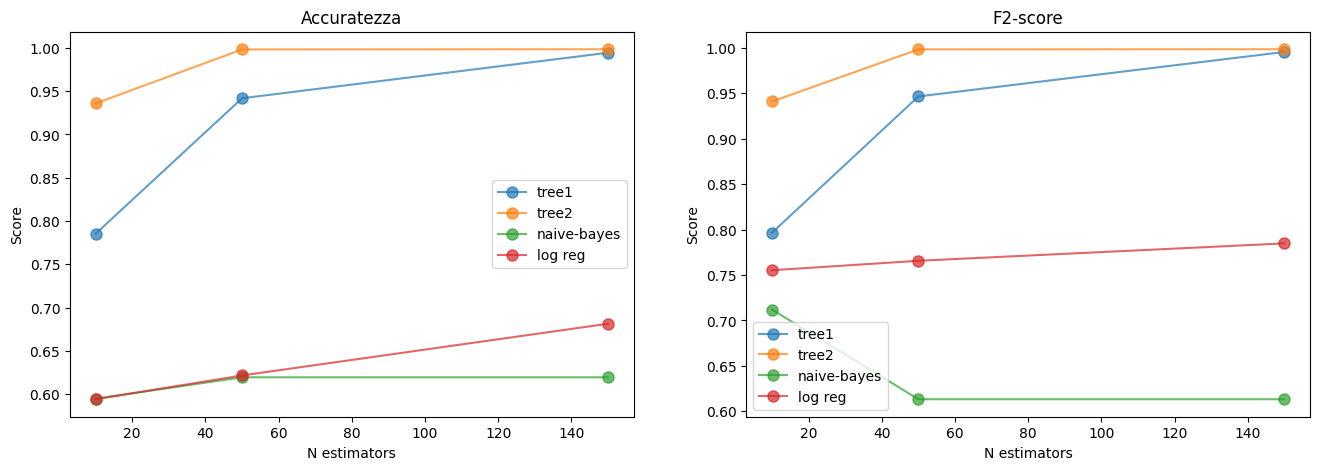

In [137]:
acc_v = []
f2_v = []
my_est=['tree1', 'tree2', 'naive-bayes', 'log reg']
for e in estimators:
  acc = []
  f2 = []
  for elem in adas:
    if elem.get_alg()==e:
      acc.append(elem.get_acc())
      f2.append(elem.get_f2())
  acc_v.append(acc)
  f2_v.append(f2)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for i in range(0, len(estimators)):
  axes[0].plot(n_estimators, acc_v[i], 'o-', markersize=8, alpha=0.7, label=my_est[i])
  axes[1].plot(n_estimators, f2_v[i], 'o-', markersize=8, alpha=0.7, label=my_est[i])
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('N estimators')
axes[0].set_ylabel('Score')
axes[1].set_xlabel('N estimators')
axes[1].set_ylabel('Score')

axes[0].set_title('Accuratezza')
axes[1].set_title('F2-score')
plt.show()

MAX f2_score:  0.9986189312652712
for estimator:  tree 2 , and number of estimators:  150
MAX f3_score:  0.9986012500221322
for estimator:  tree 2 , and number of estimators:  150
MAX accuracy:  0.9985262571844963
for estimator:  tree 2 , and number of estimators:  150


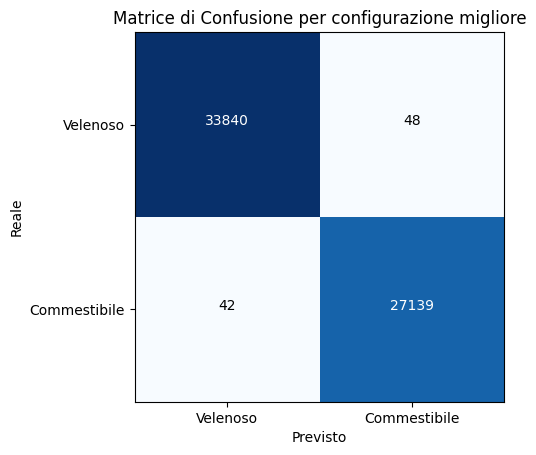

In questa configurazione abbiamo accuracy: 0.9985262571844963 e f2-score: 0.9986189312652712


In [138]:
print("MAX f2_score: ",ada_maxs[0][0])
print("for estimator: ", ada_maxs[0][2],", and number of estimators: ",ada_maxs[0][1])

print("MAX f3_score: ",ada_maxs[1][0])
print("for estimator: ", ada_maxs[1][2],", and number of estimators: ",ada_maxs[1][1])

print("MAX accuracy: ",ada_maxs[2][0])
print("for estimator: ", ada_maxs[2][2],", and number of estimators: ",ada_maxs[2][1])
for elem in adas:
  if elem.get_n_est() == ada_maxs[0][1]:
    if elem.get_alg() == ada_maxs[0][2]:
          ConfusionMatrixDisplaySingle(elem.get_conf(), 'configurazione migliore')
          plt.show()
          print("In questa configurazione abbiamo accuracy:", elem.get_acc(),"e f2-score:", elem.get_f2())



## Risultati
Vista la tipologia del dataset abbiamo deciso di confrontare i modelli dando priorità all'f2-score, che ci è sembrata la metrica più rilevante. Dal grafico sottostante possiamo vedere come si comportano le migliori configurazioni per ciascun algoritmo di classificazione esaminato. Dai risultati, possiamo vedere come Knn, Adaboost, Multilayer perceptron e Kernel density hanno tutti un'ottima f2, anche decision tree ha un'ottima f2 ma leggermente inferiore. Andando a ingrandire il grafico, si vede come kernel density risulta essere il migliore, con un'f2-score molto vicino all'1.

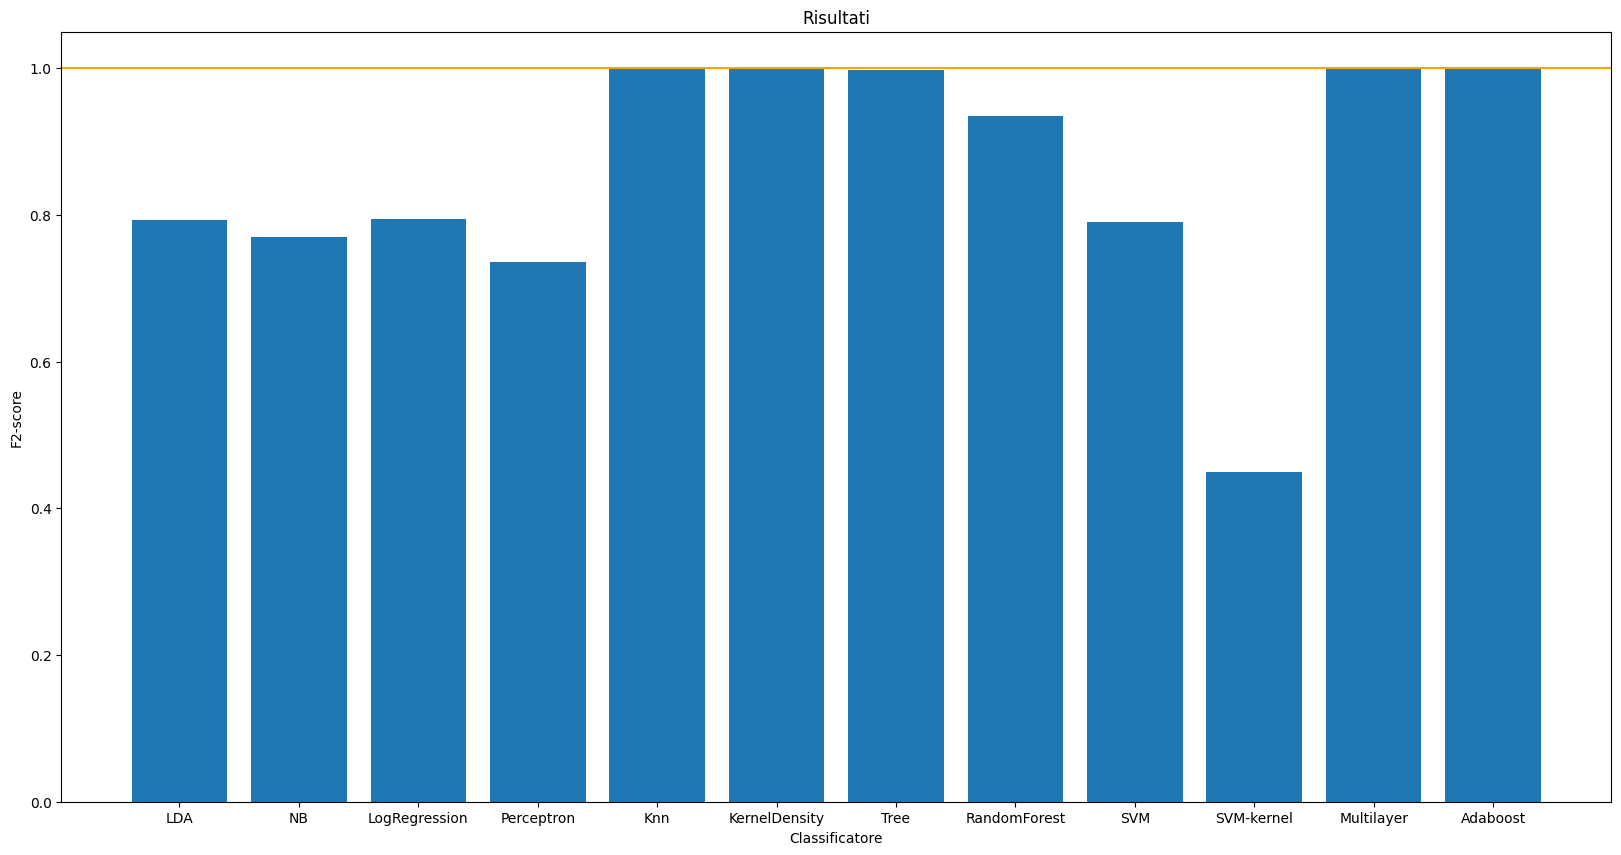

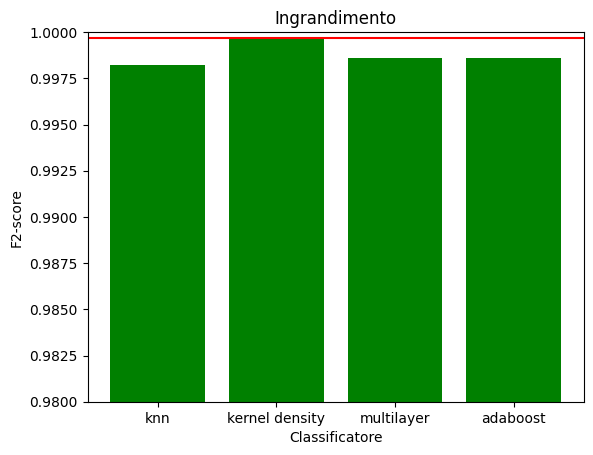

In [159]:
categorie = ['LDA', 'NB', 'LogRegression', 'Perceptron', 'Knn', 'KernelDensity', 'Tree', 'RandomForest', 'SVM', 'SVM-kernel', 'Multilayer', 'Adaboost']
valori = [f2_score_LDA, f2_score_NB, max_log[0][0], max_perc, knn_maxs[0][0], kds_maxs[0][0], maxs[0][0], forest_maxs[0][0], svm_maxs[0][0], k_maxs[0][0], mlpc_maxs[0][0], ada_maxs[0][0]]
plt.figure(figsize=(20,10))
# Creazione del grafico a barre
plt.bar(categorie, valori)
my_max = 0
for i in valori:
  if i > my_max:
    my_max = i
plt.axhline(y=my_max, color='orange')


# Personalizzazione del grafico
plt.xlabel('Classificatore')
plt.ylabel('F2-score')
plt.title('Risultati')

# Mostra il grafico
plt.show()

g_cat = ['knn', 'kernel density', 'multilayer', 'adaboost']
g_val = [knn_maxs[0][0], kds_maxs[0][0], mlpc_maxs[0][0], ada_maxs[0][0]]
plt.ylim(0.98, 1)
plt.bar(g_cat, g_val, color='green')
plt.xlabel('Classificatore')
plt.ylabel('F2-score')
plt.title('Ingrandimento')
plt.axhline(y=my_max, color='red')
plt.show()

## Feature selection
Dopo aver fatto l'analisi dell'algoritmo di classificazione migliore per il nostro task, ci siamo chiesti se non fosse possibile migliorare ancora i risultati andando ad effettuare feature selection, quindi abbiamo visualizzato la matrice di varianza-covarianza tra le diverse feature per vedere se ci fossero feature strettamente correlate tra loro da eliminare per semplificare il modello. In realtà, probabilmente a causa del basso numero di feature presente nel nostro dataset, come si può vedere dalla matrice sottostante la feature selection non si è rivelata necessaria. Ci sono solo due feature correlate, stem-width com cap-diameter, ed eliminare un'unica feature non produce una semplificazione abbastanza significativa da giustificare l'applicazione di feature selection.

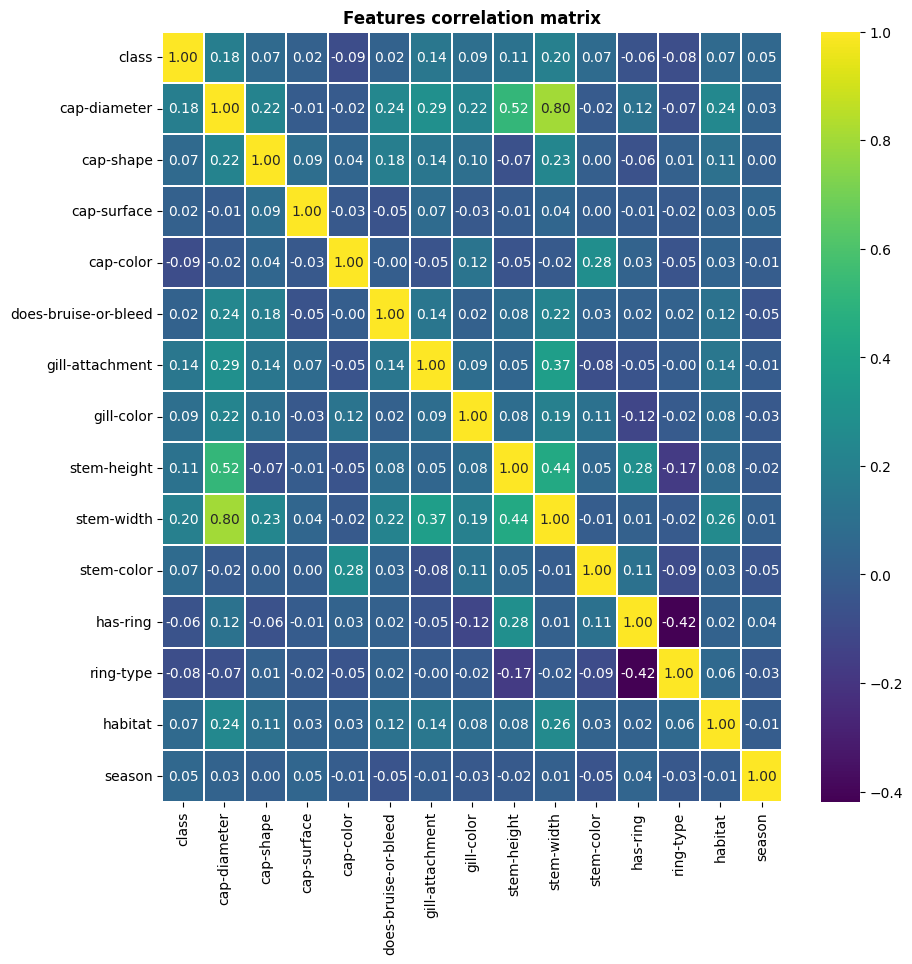

In [162]:
encoded_data = df.copy()
le = LabelEncoder()
encoded_data['class'] = le.fit_transform(df['class'])

for col in encoded_data.columns:
    encoded_data[col] = le.fit_transform(encoded_data[col])

dfDummies = encoded_data
plt.figure(figsize=(10,10))
sns.heatmap(dfDummies.corr(), linewidths=.3, cmap="viridis", annot=True, fmt=".2f")
plt.title('Features correlation matrix', fontweight="bold")
plt.yticks(rotation=0)
plt.show()